In [1]:
# import all libraries
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse


In [2]:
# ## Source code for unpickle function: https://www.cs.toronto.edu/~kriz/cifar.html
# def unpickle(file):
#     import pickle
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo, encoding='bytes')
#     return dict

# import numpy as np
# def get_mean_color():
#     d=unpickle('./data/cifar-10-batches-py/data_batch_1')
#     channels = d[b'data']
#     for i in range(2,6):
#         d=unpickle('./data/cifar-10-batches-py/data_batch_'+str(i))
#         channels=np.concatenate((channels, d[b'data']), axis=0)
#     r=np.mean(channels[:,:1024])/255  
#     g=np.mean(channels[:,1024:2048])/255
#     b=np.mean(channels[:,2048:])/255
#     return(r,g,b)
# get_mean_color()

In [3]:
# these are commonly used data augmentations
# random cropping and random horizontal flip
# lastly, we normalize each channel into zero mean and unit standard deviation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    
    transforms.ToTensor(),
    #transforms.RandomErasing(value=get_mean_color()),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [4]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
print(len(trainset), len(testset))

73257 26032


#Data Augmentation
Data augmentation performs random modifications of the image as a preprocessing step. It serves the following purposes:
1. It increases the amount of data for training.
2. By deleting features, it prevents the network from relying on a narrow set of features, which may not generalize.
3. By changing features while maintaining the same output, it helps the network become tolerant of changes that do not change the image lab. 

In short, data augmentation desensitivizes the network, so it extracts features that are invariant to changes that should not affect the prediction. 

We showcase a few random data augmentation provided by PyTorch.

In [5]:
# import torch.nn as nn
# transforms = torch.nn.Sequential(
#     T.Resize(256), # resize the short edge to 256.
#     T.RandomCrop(224), #randomly crop a 224x224 region from the image
#     T.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
#     #T.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0.1)
#     #T.AutoAugment()
# )

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# dog1 = dog1.to(device)
# # dog2 = dog2.to(device)

# # transformed_dog1 = transforms(dog1)
# transformed_dog1 = transforms(dog1)
# show([transformed_dog1])

In [6]:
# Training
def train(epoch, net, criterion, trainloader, scheduler):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
          print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

Test performance on the test set. Note the use of `torch.inference_mode()`

In [7]:
def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total



In [8]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')





In [9]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


[3234. 8926. 6868. 5501. 4828. 4429. 3753. 3516. 3233. 2937.]
[0.06848068 0.18901006 0.14543145 0.11648491 0.10223399 0.09378507
 0.07947062 0.07445209 0.0684595  0.06219164]


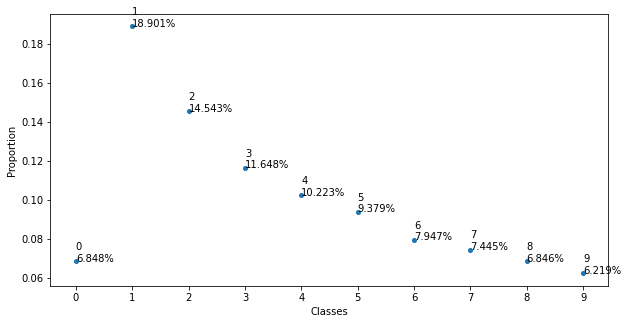

In [10]:
# partition the trainset
torch.manual_seed(0)
np.random.seed(0)
new_trainset, validationset= torch.utils.data.random_split(trainset,
  [len(trainset)-len(testset), len(testset)], generator=torch.Generator().manual_seed(0))
class_freq = np.zeros(10)
for i in range(len(new_trainset)):
  class_freq[new_trainset[i][1]]+=1
class_prop = class_freq/(len(new_trainset))
print(class_freq)
print(class_prop)

# plot the proportion
ax = plt.figure(figsize=(10,5)).add_subplot(111)
plt.plot(list(classes),class_prop, '.', ms=8)
plt.xlabel("Classes")
plt.ylabel("Proportion")
for i,j in zip(list(classes),class_prop):
    ax.annotate(i+'\n'+str(round(j*100,3))+'%',xy=(i,j))
plt.show()

In [11]:
sum(class_freq)

47225.0

In [12]:
# main body
config = {
    'lr': 0.001,
    'weight_decay': 0
}


trainloader = torch.utils.data.DataLoader(
        new_trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
        validationset, batch_size=128, shuffle=False, num_workers=2)
net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
#scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=300)

train_loss_list=[] 
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

for epoch in range(1, 301):
    train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler)
    test_loss, test_acc = test(epoch, net, criterion, testloader)
    
    train_loss_list.append(train_loss) 
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, test loss " + \
      ": %0.4f, test accuracy : %2.2f") % (epoch, train_loss, train_acc, test_loss, test_acc))



Epoch: 1
iteration :  50, loss : 2.2629, accuracy : 19.09
iteration : 100, loss : 2.0071, accuracy : 28.93
iteration : 150, loss : 1.7155, accuracy : 39.86
iteration : 200, loss : 1.4762, accuracy : 48.68
iteration : 250, loss : 1.2985, accuracy : 55.09
iteration : 300, loss : 1.1735, accuracy : 59.54
iteration : 350, loss : 1.0810, accuracy : 62.96
Epoch :   1, training loss : 1.0505, training accuracy : 64.05, test loss : 0.6002, test accuracy : 81.17

Epoch: 2
iteration :  50, loss : 0.4500, accuracy : 86.11
iteration : 100, loss : 0.4446, accuracy : 86.12
iteration : 150, loss : 0.4345, accuracy : 86.31
iteration : 200, loss : 0.4331, accuracy : 86.35
iteration : 250, loss : 0.4196, accuracy : 86.78
iteration : 300, loss : 0.4127, accuracy : 87.09
iteration : 350, loss : 0.4123, accuracy : 87.10
Epoch :   2, training loss : 0.4103, training accuracy : 87.15, test loss : 0.4387, test accuracy : 86.57

Epoch: 3
iteration :  50, loss : 0.3501, accuracy : 88.92
iteration : 100, loss :

In [13]:
# the hold-out test set
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)
test_loss, test_acc = test(0, net, criterion, testloader)
test_loss, test_acc

(0.4382414690711919, 94.27243392747388)

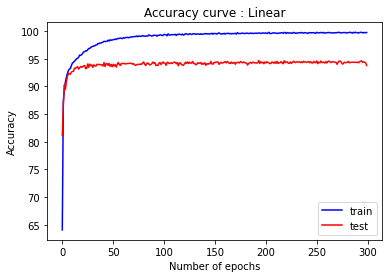

In [14]:
plt.plot(range(len(train_acc_list)), train_acc_list, 'b')
plt.plot(range(len(test_acc_list)), test_acc_list, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curve : Linear")
plt.legend(['train', 'test'])
plt.show()

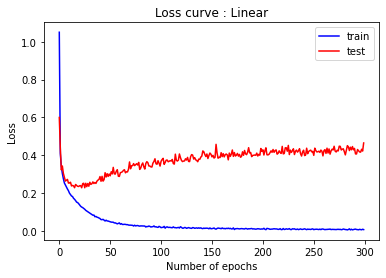

In [15]:
plt.plot(range(len(train_loss_list)), train_loss_list, 'b')
plt.plot(range(len(test_loss_list)), test_loss_list, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss curve : Linear")
plt.legend(['train', 'test'])
plt.show()

In [16]:
print(f"train_loss_list_linear = {train_loss_list}") 
print(f"train_acc_list_linear = {train_acc_list}")
print(f"test_loss_list_linear = {test_loss_list}")
print(f"test_acc_list_linear = {test_acc_list}")

train_loss_list_linear = [1.0505396097010067, 0.41031305952285363, 0.34015994405924144, 0.3038505317194029, 0.27671615290771007, 0.2539030461090044, 0.24293845730422312, 0.2313264879753919, 0.22205986383403867, 0.21279181394635177, 0.20017173882260877, 0.19267895106014196, 0.18516845405505603, 0.18218227440546844, 0.17281363284604012, 0.16757936995264475, 0.1608044776490064, 0.1526946394343363, 0.1503949542921087, 0.14460325269861435, 0.1379334318267338, 0.13074936200347212, 0.12652073063834654, 0.12361395870888137, 0.11955785878043027, 0.11495751238915171, 0.10918548092407586, 0.10549298947964741, 0.10151599690843081, 0.09746526491886312, 0.09452159306524084, 0.09095732697353857, 0.08772212413056352, 0.08348307219462667, 0.08420775942554884, 0.07539896097104885, 0.07707164484154443, 0.07315899130855473, 0.07151561531902047, 0.06873627238071506, 0.06587666986752452, 0.060232834865876696, 0.059981180607343754, 0.06175297403930204, 0.05708458852451951, 0.05296678836066225, 0.057111382709

In [17]:
train_loss_list_01 = [2.3849518770770977, 2.2417600981911345, 2.2415069635644516, 2.2409557133186153, 2.2419579268147953, 2.240125378942102, 2.240931454066662, 2.2417839348800785, 2.242252948807507, 2.241471426273749, 2.241231945472035, 2.2413479971691843, 2.241036834432504, 2.2407813569717616, 2.2415969093963706]
train_acc_list_01 = [18.56855479089465, 18.617257808364215, 18.746426680783483, 18.60243515087348, 18.61937533086289, 18.886183165696135, 18.60243515087348, 18.598200105876124, 18.604552673372154, 18.740074113287452, 18.731604023292746, 18.814187400741133, 18.848067760719957, 18.82901005823187, 18.752779248279513]
test_loss_list_01 = [2.2387831538331273, 2.241503697984359, 2.241926829020182, 2.240557459055209, 2.2406100852816713, 2.252836311564726, 2.2468298743752873, 2.2446437150824305, 2.2425780202828203, 2.240177970306546, 2.243702617346072, 2.2441832843948815, 2.253918958645241, 2.245230858232461, 2.2435202879064224]
test_acc_list_01 = [18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 14.27858020897357, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463, 18.95743700061463]
train_loss_list_001 = [2.2888378896687414, 2.232192633274771, 1.4893088792236193, 0.5001831288098643, 0.3830500937251218, 0.32867970416539405, 0.29770232389774426, 0.27895135900919354, 0.2627035691970732, 0.24814978033950336, 0.23438045485475198, 0.2243682525668364, 0.21301924496848731, 0.20818865677811266, 0.1958482328166322]
train_acc_list_001 = [18.50926416093171, 18.968766543144522, 47.80307040762308, 84.23292747485442, 88.15881418740074, 89.9142403388036, 91.04923239809423, 91.63790365272631, 92.08893594494441, 92.58020116463737, 93.03758602435151, 93.36791953414505, 93.715193223928, 93.84012705134992, 94.35044997353097]
test_loss_list_001 = [2.2451091665847627, 2.2302937355695986, 0.684039752711268, 0.4374444575286379, 0.39873581839834943, 0.36398082489476485, 0.3313831433507742, 0.3210300371854329, 0.2847569804346445, 0.29315854806233854, 0.27853756525791157, 0.26896954926789973, 0.2596830692069203, 0.26028463620619446, 0.2491153629460171]
test_acc_list_001 = [18.88060848186847, 19.053472649047325, 78.20759065765212, 86.33988936693301, 87.90334972341734, 88.90596189305471, 90.08143822987093, 90.81515058389674, 91.70636140135218, 91.54118008604794, 91.8638598647818, 92.2480024585126, 92.43239090350338, 92.50537799631223, 92.82037492317149]
train_loss_list_0001 = [1.8565612323885041, 0.5532636212785715, 0.4003713336094285, 0.3402645644860539, 0.309145948165639, 0.2848975209968523, 0.262982070708501, 0.24855145600026216, 0.2386487888167221, 0.2278864942390098, 0.21327269485164788, 0.20556094100683686, 0.19517452138549268, 0.18913837452608395, 0.18232752032436653]
train_acc_list_0001 = [34.7993647432504, 82.35468501852831, 87.65272631021705, 89.51614610905241, 90.6723133933298, 91.51932239280042, 92.26892535733192, 92.59925886712546, 92.97617787188989, 93.34674430915828, 93.69401799894123, 93.97353096876654, 94.31868713605083, 94.53255690841715, 94.71254632080466]
test_loss_list_0001 = [1.0861167063315709, 0.46979708385233787, 0.41340532643245714, 0.3364271931350231, 0.3262409484561752, 0.34040282589986043, 0.28803076817854945, 0.2942232322678262, 0.2779932311169949, 0.27514038454083833, 0.2478603608906269, 0.2512748020463714, 0.26197264781769586, 0.2462065773194327, 0.24985540344142446]
test_acc_list_0001 = [64.00583896742471, 85.58312845728334, 87.41933005531654, 89.81637984019667, 89.970036877689, 89.99308543331284, 91.59111862323294, 91.35295021511985, 91.82928703134604, 92.03672403196066, 92.76275353411187, 92.83574062692071, 92.90488629379226, 92.98555623847572, 92.87031346035648]
train_loss_list_00001 = [1.2440541174192092, 0.4583125376927497, 0.36052036624613815, 0.3151768069603256, 0.2875107263081119, 0.26835051384883196, 0.25187577066948097, 0.23390740957767336, 0.22118305101950317, 0.21190600004299545, 0.20555683115350845, 0.1952596850249018, 0.18612936185546683, 0.18178928815090883, 0.17480877608181986]
train_acc_list_00001 = [57.18581259925887, 85.53943885653786, 88.79618845950239, 90.25304393859184, 91.214399152991, 92.01058761249338, 92.36421386977237, 93.09899417681312, 93.43991529910005, 93.80412916887242, 93.86765484383271, 94.25092641609317, 94.500794070937, 94.64478560084702, 94.82477501323451]
test_loss_list_00001 = [0.5935118007017117, 0.43328142947718207, 0.3668157114994292, 0.34575528556517526, 0.3590214093964474, 0.3134572241893586, 0.2903973020467104, 0.28062032824199573, 0.26905518266208034, 0.26447016406146917, 0.27132851287138227, 0.26421160440818936, 0.25491809147391836, 0.24584030433028353, 0.2630316608895858]
test_acc_list_00001 = [80.93500307314075, 86.63567916410571, 88.97510755992624, 89.3438844499078, 88.99431468961278, 90.58466502765826, 91.54502151198525, 91.56422864167179, 92.02135832821143, 92.25184388444991, 91.97910264290104, 92.37861094038107, 92.72433927473878, 92.96250768285188, 92.59757221880763]





# train_loss_list_001 = [1.5218167792493924, 1.0340943300305083, 0.7934107637633911, 0.6561045421959874, 0.5800367868936862, 0.5100019117132925, 0.4574989944982072, 0.4208847186245476, 0.3881891872079228, 0.35861467820006054, 0.3339165490084944, 0.3111862796849717, 0.2948872684575498, 0.27018505394363557, 0.25883166084940823]
# train_acc_list_001 = [44.0975, 63.055, 72.2075, 77.0575, 79.93, 82.43, 84.0575, 85.47, 86.5625, 87.675, 88.48, 89.16, 89.645, 90.5075, 90.9225]
# test_loss_list_001 = [1.3665137306044373, 1.0809951907471766, 0.8369579171832604, 0.7580914105041118, 0.6663558483123779, 0.7236429437806334, 0.5709026199352892, 0.5137608224832559, 0.5140901245648348, 0.48385591937016836, 0.47491426897954336, 0.5022718974306614, 0.5243912806993798, 0.42129093069064466, 0.4074777747634091]
# test_acc_list_001 = [52.13, 63.83, 71.47, 73.82, 77.34, 76.49, 80.87, 82.32, 82.77, 83.6, 84.17, 83.3, 83.55, 86.28, 86.86]
# train_loss_list_01 = [1.8962965864723864, 1.472022865146113, 1.2269341696184664, 1.0348994015885618, 0.9050399440165144, 0.7892040218027255, 0.6947498847120486, 0.6181783355272616, 0.5774767158892208, 0.5502305545936377, 0.5206893583456167, 0.5026034010104097, 0.4774538204311944, 0.4683271567471111, 0.4492297477710742]
# train_acc_list_01 = [31.045, 45.415, 55.22, 62.9525, 67.66, 72.095, 75.7825, 78.6325, 80.1775, 80.8325, 82.04, 82.7775, 83.69, 83.865, 84.6225]
# test_loss_list_01 = [1.6557437422909314, 1.5662637073782426, 1.1888765285286722, 1.1435910184172136, 0.9932384845576708, 0.7845515208908275, 0.7405012536652481, 0.7023888849004915, 0.6914112718799447, 0.8937227891970284, 0.6744754122027868, 0.7125071339969393, 0.595223272148567, 0.6645651912387414, 0.5624623864511901]
# test_acc_list_01 = [38.54, 45.39, 57.61, 59.19, 65.26, 72.6, 74.56, 76.24, 76.7, 71.16, 77.34, 75.59, 80.06, 77.85, 81.28]
# train_loss_list_0001 = [1.6901012103016766, 1.282657652045972, 1.0717586383652002, 0.940055356619838, 0.8364242675205389, 0.7547609810821545, 0.6785155514749094, 0.6320573160061821, 0.5852954303875518, 0.5420240767466755, 0.506621429809747, 0.47925190327647393, 0.4483506758563435, 0.4286465794800189, 0.40272510780122717]
# train_acc_list_0001 = [37.2, 53.36, 61.4225, 66.4725, 70.2, 73.2275, 76.08, 77.8025, 79.53, 80.905, 82.42, 83.1425, 84.5575, 85.195, 86.005]
# test_loss_list_0001 = [1.4665760239468346, 1.2375031430510026, 1.0847761902628066, 1.0535234567485279, 0.8635394460038294, 0.757294207434111, 0.7295623666877988, 0.7312412850464447, 0.7336276015148887, 0.6307676260984396, 0.6266382736495778, 0.6370392079594769, 0.5392829055273081, 0.5410988666588747, 0.5530912065053288]
# test_acc_list_0001 = [46.98, 55.76, 61.4, 63.25, 69.13, 73.23, 74.32, 74.64, 73.96, 78.38, 78.25, 78.58, 81.0, 81.49, 81.32]

train_loss_list_cut = [1.613359474907287, 1.186605121571416, 0.9613291156558564, 0.8175660327981455, 0.7329503829105974, 0.6675834229198127, 0.6155491586500844, 0.5636878716298186, 0.5260912411319562, 0.5027581219094249, 0.4726218120834698, 0.44723697268543916, 0.43208082353535554, 0.41164722000828946, 0.3974420052652542, 0.3826391176103403, 0.35894755928661115, 0.3507439031863746, 0.34107909901454425, 0.32801356564124173, 0.3124787288542373, 0.31465199137457645, 0.298767308029123, 0.28487236778766584, 0.27646335530966615, 0.27320462827103587, 0.26612033452184053, 0.26308306258993025, 0.2525483318411123, 0.24124891794146822, 0.24217433363389665, 0.23168825182004477, 0.23012469901730076, 0.21693348256162942, 0.21930161923074876, 0.21653421889669217, 0.21434410071125426, 0.20718723166579256, 0.2052558541250305, 0.19716152494041303, 0.1941497164983719, 0.19097941378339792, 0.18447992457939794, 0.18228636479701477, 0.17657887242948667, 0.17477260330043282, 0.1733962548212312, 0.17061091698825168, 0.16732201631219623, 0.1637549052556483, 0.1613706673700779, 0.16051728827075457, 0.15993363755389142, 0.15627589414770993, 0.15532852677158274, 0.15280420149858007, 0.15101519260353174, 0.14880275238341037, 0.13978494027742563, 0.14830744789002803, 0.14331960949463585, 0.13924681502409256, 0.13707038418601114, 0.1308897960062225, 0.13411890785581768, 0.13409768981627002, 0.13344513029217148, 0.1273199183205827, 0.1283481349103367, 0.12471981016924968, 0.1280518789260913, 0.12418704933394639, 0.12167530884139073, 0.12545658500430684, 0.11795977773234105, 0.11789289145423962, 0.12059933257202943, 0.11666790398355491, 0.11807365684558789, 0.11512304616931338, 0.11561917723082125, 0.11491954412323217, 0.11419005636661388, 0.10912806965624944, 0.11002509410198504, 0.11631911551466766, 0.10705401468129394, 0.1092875181331326, 0.10784903160942058, 0.10965043486069186, 0.10153051761511606, 0.1083350477579493, 0.10791226423467501, 0.10326221440665828, 0.10488084647149895, 0.100699621469925, 0.1017464189983595, 0.1026811115919782, 0.10191941613587327, 0.10146693645503384, 0.0997033108370944, 0.09700418662386961, 0.09839744385653221, 0.09619725261109706, 0.0990427272757307, 0.0953601595407096, 0.09479633424157342, 0.09373613773062588, 0.09360281742228486, 0.09450248972224161, 0.0905749333885531, 0.09483718122251499, 0.094004499824188, 0.09207623065731967, 0.0874123571696468, 0.08727556101073282, 0.09273509363444468, 0.08398670141106121, 0.08792692410964935, 0.08606394986732128, 0.08853992108648387, 0.08270674364302105, 0.08553103019539922, 0.08325290489799013, 0.08070171735109613, 0.08357380274028633, 0.0855067997409132, 0.07974059663760585, 0.07902837820208301, 0.07707989068862539, 0.08178071627101768, 0.07777025827025168, 0.0837722305065622, 0.07823536036232599, 0.07849429675731986, 0.08163950307229266, 0.0772132684176151, 0.0742708618630664, 0.07653025378839086, 0.07370652056361635, 0.07428970992767488, 0.066969591103637, 0.07278624822656377, 0.0711755252714022, 0.07434361697005007, 0.0714579665521606, 0.06873778960468194, 0.06797652607099317, 0.06636746319385763, 0.06754642966004035, 0.07100995908232448, 0.07219889727584757, 0.06691185421884631, 0.06648011294047768, 0.06790807842018125, 0.06884961091755583, 0.06649817791454994, 0.06520170254853015, 0.06067689375196116, 0.06284649541583685, 0.058577289441808726, 0.06126952098277859, 0.05914597977369357, 0.06332467258952487, 0.057384233588513474, 0.055878468872473455, 0.0626550735429691, 0.05836306477245241, 0.058223563505294985, 0.05526084442453358, 0.05660795328168633, 0.0533848489447238, 0.05570016410677863, 0.052253410154685806, 0.053411352781418224, 0.05460695667971913, 0.051183629400147417, 0.053861447934287425, 0.05485730031029152, 0.05130477134769146, 0.04791999825934014, 0.0483061204941128, 0.04967576256259895, 0.045770330684848676, 0.04519799896501028, 0.04884168341720161, 0.04494558678963742, 0.04718005882141689, 0.044031581079688506, 0.04476618649699865, 0.043659136812098494, 0.04084714540554145, 0.04083325983599399, 0.04264434854375026, 0.04191593292166297, 0.03981593097694004, 0.043085993813594785, 0.040142026240416705, 0.03974097740119353, 0.037398707843162474, 0.03773854231051268, 0.035977833013172256, 0.037191637455464936, 0.03843252851401631, 0.03596398131787991, 0.03615279636307123, 0.03480513299854038, 0.034845688106557623, 0.03309281391743273, 0.03143419835645075, 0.030938323252438643, 0.031188237175833397, 0.032819104747632485, 0.03191146987844437, 0.03148931583624702, 0.030030576116479815, 0.03224378252050843, 0.03121553240239787, 0.02776832960601063, 0.02880164314531528, 0.029192425741311222, 0.030026258470062107, 0.029695636324269085, 0.027793155418494687, 0.026486221334551828, 0.026275856554293976, 0.025177531725408646, 0.025483246410664278, 0.023590462400574986, 0.025644099438033356, 0.027068594341187146, 0.02301408553766771, 0.02522345676426047, 0.023035302803220865, 0.021253975071444418, 0.02299421675913869, 0.022151207279476424, 0.02280317421388119, 0.022020146825734655, 0.019744288622618865, 0.021754962591507946, 0.02058648679832431, 0.019481258098625193, 0.018746506298904102, 0.02082187346794223, 0.019484504032284973, 0.018540539403487676, 0.018026220258518744, 0.018277281947350635, 0.019090669363150937, 0.018498932709917426, 0.016855266360646357, 0.017087985687076854, 0.01755107378292555, 0.0162497674808287, 0.016687223960023624, 0.01735119057555918, 0.016141063884457057, 0.015963702109648276, 0.01607858874766638, 0.015593683267140184, 0.017362511261907843, 0.015086121411217502, 0.014080422949388076, 0.01572396905130198, 0.01647015061964409, 0.015150130807850569, 0.014522404045821688, 0.015314155997271045, 0.014406249093742798, 0.014474769565128028, 0.014898723138633151, 0.014346211947822056, 0.013767596740370836, 0.012941224452929376, 0.01388948843457376, 0.013728754877591856, 0.012941669198511817, 0.013923830428598122, 0.01301820403204475, 0.013493596776626622, 0.014167216677105608, 0.012224345361983505, 0.013615870727791479, 0.014401413207968916, 0.013055011124228137, 0.013154573026321495, 0.013493608308438295, 0.012507462098944587, 0.012766335765792492, 0.013181844661488367, 0.013105310207699982, 0.014206890060682409, 0.01374277858861005, 0.012588148265660475, 0.013434472534368141, 0.013608296886800576, 0.012433568900153517, 0.012731193249246266, 0.012850580789437429]
train_acc_list_cut = [40.9, 57.2025, 65.81, 71.35, 74.33, 76.565, 78.5275, 80.4, 81.7075, 82.5125, 83.585, 84.51, 85.1225, 85.4725, 85.9375, 86.5425, 87.3725, 87.685, 88.0775, 88.5075, 89.195, 88.7475, 89.465, 89.89, 90.23, 90.4575, 90.6025, 90.64, 91.0475, 91.385, 91.485, 91.8375, 91.855, 92.455, 92.2575, 92.455, 92.4025, 92.6625, 92.92, 93.085, 93.19, 93.35, 93.635, 93.515, 93.77, 93.805, 93.8825, 93.9425, 94.15, 94.27, 94.3925, 94.3325, 94.4625, 94.545, 94.6175, 94.6675, 94.66, 94.7825, 95.1875, 94.845, 94.9125, 95.1, 95.2425, 95.45, 95.28, 95.2525, 95.3375, 95.6875, 95.58, 95.74, 95.56, 95.7275, 95.7375, 95.7325, 95.96, 96.0225, 95.8975, 95.9725, 95.9975, 96.035, 95.935, 96.0, 96.1025, 96.3225, 96.3075, 96.0575, 96.32, 96.3125, 96.3075, 96.26, 96.575, 96.3125, 96.3875, 96.495, 96.4125, 96.585, 96.49, 96.455, 96.4925, 96.4725, 96.6375, 96.6125, 96.715, 96.775, 96.675, 96.7725, 96.7825, 96.7825, 96.775, 96.835, 96.9425, 96.72, 96.7375, 96.8475, 97.035, 97.0625, 96.845, 97.2175, 97.06, 97.1575, 97.055, 97.2325, 97.125, 97.2375, 97.315, 97.2125, 97.1925, 97.2775, 97.3325, 97.45, 97.25, 97.395, 97.23, 97.3725, 97.355, 97.2325, 97.4625, 97.4875, 97.4075, 97.545, 97.5525, 97.7425, 97.545, 97.6125, 97.505, 97.635, 97.7125, 97.72, 97.8225, 97.78, 97.6175, 97.5975, 97.86, 97.7825, 97.7725, 97.7525, 97.8075, 97.7875, 97.9775, 97.96, 98.1425, 97.9675, 98.0225, 97.88, 98.1, 98.2375, 97.9275, 97.995, 98.0375, 98.2175, 98.12, 98.26, 98.185, 98.2625, 98.275, 98.23, 98.285, 98.2475, 98.195, 98.36, 98.48, 98.4025, 98.315, 98.4725, 98.5175, 98.4075, 98.5175, 98.46, 98.535, 98.48, 98.6225, 98.6675, 98.72, 98.5975, 98.6575, 98.68, 98.525, 98.7025, 98.715, 98.78, 98.8, 98.845, 98.7975, 98.75, 98.835, 98.8225, 98.8975, 98.9, 98.925, 99.045, 98.995, 99.0175, 99.0025, 98.97, 98.9425, 99.075, 98.945, 98.9975, 99.07, 99.0825, 99.0525, 99.0625, 99.0075, 99.085, 99.2075, 99.19, 99.2475, 99.1775, 99.265, 99.1775, 99.1425, 99.255, 99.21, 99.215, 99.34, 99.245, 99.29, 99.28, 99.3, 99.3725, 99.3175, 99.3475, 99.4, 99.41, 99.2975, 99.4, 99.44, 99.45, 99.4325, 99.425, 99.4025, 99.4775, 99.44, 99.4275, 99.495, 99.4925, 99.4575, 99.485, 99.5075, 99.5, 99.5075, 99.425, 99.535, 99.5825, 99.4725, 99.5025, 99.5375, 99.545, 99.53, 99.58, 99.5525, 99.5425, 99.5775, 99.58, 99.635, 99.605, 99.59, 99.605, 99.6075, 99.65, 99.59, 99.58, 99.6125, 99.575, 99.5775, 99.59, 99.59, 99.585, 99.6075, 99.5975, 99.61, 99.635, 99.5625, 99.6, 99.6175, 99.5925, 99.6075, 99.6225, 99.5925, 99.615]
test_loss_list_cut = [1.4791154242769073, 1.1658613644068754, 0.9872214477273482, 0.8314349047745331, 0.9944802085055581, 0.7577941908112055, 0.7259182379215579, 0.6789853301229356, 0.7040932129455518, 0.6710618870167793, 0.5932643009891992, 0.7190747709968422, 0.5915243693544895, 0.5677886009216309, 0.5548223072214972, 0.48938161738311187, 0.5485320487354375, 0.5049594323846358, 0.5024378439293632, 0.5253199633163742, 0.545006987037538, 0.49844539429568036, 0.4618456284456615, 0.47183522431156305, 0.45087659849396233, 0.5046738835075234, 0.4737275925618184, 0.517040255326259, 0.47144785334792316, 0.43287935023066365, 0.4623851370585116, 0.4191177538301371, 0.40598977762687055, 0.39758752437332007, 0.429098657414883, 0.49839673049842254, 0.4335803312214115, 0.4391304107406471, 0.4258851580604722, 0.4272765200349349, 0.41979367031326775, 0.3996517728023891, 0.39644326382799994, 0.4050762924966933, 0.37220431883123856, 0.41266086810751806, 0.4058349334363696, 0.40598829731911046, 0.4262330528301529, 0.4142030260608166, 0.35964680000951016, 0.3874821408262736, 0.3994222947313816, 0.4099999762411359, 0.48654232843767237, 0.40172827545600603, 0.3953292958344085, 0.4276507317642622, 0.37284702835958217, 0.3759660202113888, 0.39387373701681067, 0.3743562951118131, 0.3970871818593786, 0.41597020795828177, 0.3505105532800095, 0.3577760239190693, 0.3745738009486017, 0.36575221789034107, 0.3922628566056867, 0.3804579684628716, 0.3428110468991195, 0.38194986197012887, 0.35429555196550827, 0.361780740603616, 0.3707258914467655, 0.3518540302786646, 0.3650943885875654, 0.3918004062356828, 0.3596177604756778, 0.37847324338140365, 0.40541056722779817, 0.39005918272688417, 0.3564605245107337, 0.36085661019705517, 0.41434526443481445, 0.3446986880860751, 0.3807661754043796, 0.3560769367444364, 0.3401542149389846, 0.33212360739707947, 0.34799107928064804, 0.40249927549422543, 0.3623131317428396, 0.38307136523572705, 0.3425910604905479, 0.3611237068153635, 0.37625472587120684, 0.3761880048845388, 0.3633357567500465, 0.32559320141997516, 0.3548705181743525, 0.37774981407425073, 0.33313915548445305, 0.3662335353938839, 0.34161262233046036, 0.33970868606356125, 0.33961755310810066, 0.35591573598264137, 0.36459438993206505, 0.34952369747282586, 0.3646538981908484, 0.3669853182155875, 0.346222849586342, 0.3648104143293598, 0.35329970227012153, 0.3857896882521955, 0.3397268560491031, 0.3996561256390584, 0.344681443670128, 0.35413239726537393, 0.3316430355174632, 0.38716104249410993, 0.32942197028594683, 0.35217226400405544, 0.37594665285152723, 0.34076649818239335, 0.3449836048898818, 0.3587528810470919, 0.3401296163284326, 0.3270592946983591, 0.32152744599535493, 0.3485121142260636, 0.33158980649483355, 0.35384547361467455, 0.3337541961971718, 0.31837486522861674, 0.32609030859002586, 0.35300223284129856, 0.31153832630643363, 0.331745189390605, 0.31228505301324627, 0.32915962798685966, 0.307383563322357, 0.3250211654584619, 0.32271280979053885, 0.3312963891444327, 0.3233849070494688, 0.3239633294789097, 0.3277184535996823, 0.3104742332538472, 0.32017407990709135, 0.32736679232573207, 0.31899695456782473, 0.29834681513566, 0.3152913172033769, 0.3275818183452268, 0.33088456924203075, 0.3209677238630343, 0.32485942636864096, 0.3357626995708369, 0.3363142457755306, 0.3152533290506918, 0.3161260941171948, 0.3332944193595572, 0.3038376487697227, 0.34032498092591007, 0.31091189195838154, 0.31926076189626623, 0.31000442501110365, 0.3010354260855083, 0.30018055627617657, 0.3127445231510114, 0.30238260064698474, 0.3182603884724122, 0.31473101213385785, 0.29884613908921615, 0.31703367735011667, 0.2913209448886823, 0.2881702622280845, 0.31681924888604807, 0.29637292385855807, 0.2983416555614411, 0.29558402111258686, 0.29196765764227395, 0.3100640736048735, 0.31831720773177813, 0.29677640637264974, 0.30746520772764957, 0.2865563590503946, 0.30253688547807406, 0.28961686959749533, 0.29738174973032144, 0.29680030708071553, 0.29409151684634294, 0.2892140953601161, 0.3005977722851536, 0.2880074861872045, 0.27800113717211955, 0.2859659475993507, 0.2899065754270252, 0.28989569729642023, 0.29461942848902717, 0.27184448862754845, 0.2677759771482854, 0.2699777761214896, 0.3000830202540265, 0.2926526506301723, 0.2815253124395503, 0.2683991437094121, 0.2708052956982504, 0.2659032362737233, 0.29111536092396023, 0.27172746575331386, 0.2721299055633666, 0.27334422420097304, 0.27823255380874945, 0.2846702391022368, 0.26914313680763485, 0.2824036598299878, 0.26155152982926066, 0.28833567049307157, 0.2757935132595557, 0.28530820940114276, 0.26061007040965406, 0.2689024790932861, 0.2690693513502049, 0.2623352914859977, 0.26749783254499676, 0.2726406627629377, 0.2707079539570627, 0.2750299688947352, 0.2752766144237941, 0.26105580568502224, 0.2643242926348614, 0.2672247627302061, 0.27170711321921287, 0.28075962617427486, 0.25020905593528026, 0.24921881190583675, 0.26484523855055436, 0.2614167183637619, 0.27086676525164255, 0.2653467998474459, 0.25267240150442605, 0.2534334840653818, 0.26007933452536786, 0.2619169997640803, 0.2546714186857018, 0.2537678420732293, 0.27184398217669015, 0.24711663049610355, 0.26054487415129624, 0.2526520066246202, 0.2480248349565494, 0.24464330218638045, 0.2543100225208681, 0.2467851509587674, 0.2543815068806274, 0.2550846805112271, 0.24686935845809646, 0.25780645163753363, 0.24647484842357756, 0.2498779943849467, 0.24236657725104802, 0.25234464791756644, 0.23720906674861908, 0.2444623167378993, 0.24947976245533063, 0.24974906840656377, 0.24106483623574052, 0.24051216914306714, 0.24444433122496062, 0.240749250955974, 0.24741494844231424, 0.24492908486082585, 0.24239608881217015, 0.24886162715810764, 0.24737394035239763, 0.24470583080679556, 0.23975468323200563, 0.25973454749659647, 0.24880992423129988, 0.25671024592239644, 0.2394170629072793, 0.2508298989526833, 0.25579182813061946, 0.23148325047915494, 0.2473917234736153, 0.23667787901962858, 0.24764571838741062, 0.23395111053427564, 0.23682133947746664, 0.2453216223777095, 0.2395489558200293, 0.24663213140602352, 0.2379017510934721, 0.24195825148232375, 0.23623901610321638, 0.24765730121090443, 0.24364126761314236]
test_acc_list_cut = [47.45, 60.0, 65.86, 71.15, 68.02, 74.04, 74.75, 76.5, 76.38, 77.35, 79.87, 75.79, 80.02, 80.57, 81.27, 83.4, 81.97, 82.87, 83.07, 82.72, 81.44, 83.43, 84.51, 84.41, 84.85, 83.96, 84.21, 82.61, 85.09, 85.42, 85.35, 86.23, 86.96, 86.92, 85.98, 84.21, 85.86, 85.85, 85.91, 86.93, 86.74, 86.97, 87.32, 87.19, 87.67, 86.55, 86.81, 87.37, 86.84, 87.3, 88.46, 87.92, 87.66, 87.19, 85.59, 87.67, 87.69, 86.81, 88.24, 88.24, 87.26, 88.01, 87.61, 87.88, 88.96, 88.76, 88.97, 88.92, 87.96, 88.36, 88.67, 87.88, 88.96, 88.67, 88.46, 88.99, 88.87, 88.21, 88.92, 88.53, 88.17, 88.26, 89.01, 88.57, 87.5, 89.68, 88.57, 88.93, 89.45, 89.58, 89.15, 88.23, 88.64, 88.35, 89.49, 89.34, 89.23, 88.47, 88.78, 89.82, 89.47, 89.04, 89.77, 88.77, 89.85, 89.69, 89.79, 89.18, 89.03, 89.57, 89.04, 89.3, 89.43, 89.17, 89.25, 88.69, 89.73, 88.08, 89.49, 89.59, 90.02, 88.41, 89.94, 89.77, 88.87, 89.91, 89.6, 89.29, 90.01, 90.18, 90.39, 89.52, 90.2, 89.82, 89.98, 90.55, 90.27, 89.84, 90.81, 90.16, 90.58, 90.17, 91.06, 90.49, 90.02, 90.36, 90.15, 90.41, 90.29, 91.05, 90.46, 90.37, 90.3, 91.15, 90.77, 90.49, 90.34, 90.44, 90.56, 90.45, 90.12, 90.36, 91.18, 90.31, 91.04, 90.24, 90.89, 90.56, 91.21, 91.14, 90.88, 90.8, 90.98, 90.69, 90.8, 91.24, 90.76, 91.31, 91.56, 90.68, 90.91, 91.29, 91.61, 91.43, 91.23, 90.98, 91.61, 91.17, 91.7, 91.2, 92.06, 91.39, 91.26, 91.56, 91.42, 91.42, 91.78, 91.94, 91.69, 91.44, 92.0, 91.36, 91.88, 92.07, 92.17, 91.33, 91.74, 91.8, 92.13, 92.09, 92.31, 91.55, 92.01, 92.26, 92.4, 91.8, 91.83, 92.3, 92.02, 92.56, 92.16, 92.24, 91.79, 92.59, 92.35, 92.7, 92.71, 92.45, 92.55, 92.34, 92.02, 92.56, 92.65, 92.35, 92.53, 92.23, 92.47, 92.65, 92.84, 92.75, 92.85, 92.58, 92.62, 92.95, 92.94, 92.61, 92.87, 92.93, 92.82, 92.37, 92.94, 92.82, 92.81, 93.03, 93.0, 92.85, 93.13, 92.88, 92.75, 93.02, 92.82, 93.14, 92.91, 93.07, 92.55, 93.2, 93.19, 93.02, 93.01, 93.03, 93.35, 93.0, 93.14, 92.89, 93.14, 93.2, 93.12, 93.15, 93.17, 93.22, 93.14, 93.1, 93.0, 93.72, 92.96, 92.94, 93.39, 92.96, 93.36, 93.22, 93.51, 93.28, 93.27, 93.3, 93.29, 93.18, 93.24, 93.64, 93.27, 93.29]
train_loss_list_wd5e4 = [1.5027774480965952, 1.0276084239490497, 0.7975675012356938, 0.6686166104988549, 0.5772798815474343, 0.5116038408142309, 0.461431055594557, 0.4285996074493701, 0.3872021212459753, 0.36954540337998265, 0.33349453384122146, 0.3191225348760526, 0.29570154136362164, 0.2778870724736692, 0.26335706169041584, 0.2490621807809455, 0.23208605314786443, 0.22031858939522753, 0.20280856089279675, 0.1948807320465295, 0.18225760984058959, 0.17901248411058238, 0.16944760515000493, 0.15725475339034495, 0.15281064094255525, 0.14829571347552747, 0.1351967308396539, 0.1339439639982324, 0.12818257354747373, 0.1161808082328056, 0.11971007128612111, 0.11157218916728474, 0.11184166256969158, 0.1071621371736637, 0.09870970028396041, 0.09892762057221355, 0.0908012348063552, 0.08706318784933596, 0.08129636609492401, 0.0844175164608624, 0.07711375228608378, 0.0727171496318552, 0.07881306375439365, 0.06988748621207456, 0.06977271015187517, 0.07213704411785443, 0.06465452981178467, 0.059860886116259206, 0.06565443985164165, 0.055741984914904966, 0.05937281503273656, 0.054797398726851604, 0.04783525239057339, 0.057667528927778475, 0.0519976342906253, 0.05075258484479195, 0.0479780873997857, 0.051437813953047216, 0.044275228567897514, 0.05218542266202668, 0.047849885717677045, 0.04727344876809861, 0.04353566757275369, 0.05274154159564751, 0.03900954714669778, 0.038132579750217756, 0.0438798694252468, 0.04052391117319655, 0.0444194049285814, 0.03921739171041896, 0.04322019030456059, 0.03981477512677495, 0.04147126957232627, 0.03451747147622295, 0.03873391680645581, 0.03558630044438159, 0.03961444919863448, 0.03973888016243379, 0.03753592373844915, 0.03485113727642943, 0.036234460864811184, 0.03558692057875875, 0.03258687717030747, 0.03053688010224662, 0.03501797043614256, 0.02845712277083137, 0.03135093330991821, 0.03356501266074638, 0.03350056209170019, 0.03376623985473626, 0.0308699009333032, 0.02893257925968272, 0.027391545217150984, 0.0286959023021471, 0.030725791665781942, 0.026020749267517997, 0.03082717279829204, 0.02599965874775173, 0.03394242989184995, 0.03584211132750986, 0.032864981473753815, 0.03261832850271116, 0.03152383655345383, 0.028458409716550725, 0.0237263294655425, 0.02717581400335335, 0.028603503928362084, 0.02477863742285572, 0.026328867512603348, 0.02738554204796283, 0.024270188131818946, 0.02639033293170027, 0.028431153394275915, 0.0267944870994221, 0.022552848333112014, 0.027474652415665147, 0.022996818839450376, 0.02170721744931044, 0.024480172923168005, 0.025365150559651918, 0.02576148252154644, 0.024583259466499946, 0.026209578144188506, 0.022519710091368172, 0.022190634743682446, 0.017703767737207082, 0.019398964044396966, 0.02643031852926833, 0.02380849324953787, 0.02303797679733092, 0.015461873901173318, 0.016369462731820994, 0.023921750444984333, 0.024145581647188375, 0.024439221988923062, 0.021081448698151536, 0.019269814025595806, 0.01770727836546271, 0.015750449192457307, 0.018357921256341586, 0.016851160442084668, 0.016779405207331545, 0.01922887265860749, 0.01491048913590384, 0.017494613310685175, 0.020450935306655357, 0.019253915843045036, 0.01861391122789143, 0.017561238870908397, 0.01683490170342937, 0.012796001498417827, 0.016780197644567552, 0.014076976357370067, 0.0157260496032457, 0.016004126569547784, 0.017361198594353307, 0.01750588047760018, 0.014100992143118439, 0.012314881729229857, 0.008250951137283621, 0.013473853790245878, 0.010151084203766985, 0.009842516266005918, 0.010620841719269657, 0.009969146477769667, 0.011355855877097613, 0.007406337388096372, 0.008986727931512931, 0.009986997959159387, 0.009125781858848712, 0.007472109663621567, 0.008835015864224551, 0.004292508458737998, 0.005812553818874692, 0.00677099364538924, 0.0067322269050826946, 0.004625315853274061, 0.005215383676132158, 0.006344635733596671, 0.005187604376992669, 0.003839952308653345, 0.003965519353213271, 0.002669242659610467, 0.002117635275329502, 0.002775355486739308, 0.00265736014845546, 0.0022718249013076145, 0.0020042899910497447, 0.0016117119838441976, 0.0014573458997613063, 0.001228732236187917, 0.0012267742422409356, 0.0014500122589130586, 0.0014915024765362493, 0.0012808567260394986, 0.0011165388441382767, 0.0012906825464864531, 0.001357362313477245, 0.0012554813951131897, 0.0011106275753623928, 0.0011766462907799112, 0.0011652772541354281, 0.0014127067940387006, 0.0012243740158691145, 0.0011723753179798421, 0.0012344509843341149, 0.0012428820435963451, 0.0011997493186641259, 0.001336276902967451, 0.0011452813391029217, 0.0011089205116661378, 0.001165861148571673, 0.0012621701129313452, 0.0011624022613475902, 0.0012330106737020725, 0.0011809163343030425, 0.001101714661181235, 0.0011684441624340205, 0.0011685377142329615, 0.0012322912058129478, 0.0011872104088293787, 0.001143343054307119, 0.0011744529526597394, 0.001203257890125088, 0.00115107328663714, 0.0011390011661653273, 0.0012292457904782706, 0.0011242386569215443, 0.0011883258320072802, 0.0011454876748467097, 0.001156560716423066, 0.0011528850767014627, 0.001165562277152456, 0.0011236844305395365, 0.0011447015948914967, 0.0012182490931773268, 0.0011218772364628559, 0.001162500955319157, 0.0011594401151403047, 0.001198594366161587, 0.0011824657069370388, 0.001172395464897263, 0.0012272381267998333, 0.001153445542647173, 0.0012023703809961462, 0.0011459320135334262, 0.0012018852982485589, 0.0011949562754023809, 0.0011886567682230149, 0.0011700176551697043, 0.0011815206049539792, 0.0011973182879798947, 0.0012122210003242206, 0.0011632622707971392, 0.0011874910569734894, 0.0011854940763534828, 0.0011964635884451765, 0.0011862511147771734, 0.001194577806401617, 0.0012562638589407142, 0.0012219592303293534, 0.0011857493995159221, 0.0011942158280217204, 0.0011750017043601828, 0.001190489213080547, 0.0011951297786780082, 0.0011906062601321635, 0.0011730845402048442, 0.0012332784984939206, 0.0012139175384760664, 0.0011773592329021698, 0.0012054313082075394, 0.0011924652807851926, 0.0012579563214404942, 0.001199958441122926, 0.0012173140406632386, 0.0012009810876122083, 0.001210526931255806, 0.0011779946152689143, 0.0011719051533164427, 0.001181355180083432, 0.0011896568855580191, 0.0012324937115670345, 0.0011941396765940534, 0.0011866521274376386, 0.0011868935034494287, 0.0011929624456207093, 0.0012042453618922506, 0.001203572630105665, 0.001169494700063163, 0.0012129276695946893, 0.0012054597970452337, 0.0012071873559750402, 0.0011781047958621797, 0.0011885599540055584, 0.0011778895794518126, 0.0011938168243624079, 0.0011808463227607833, 0.0012280858834437763, 0.001201700613523027]
train_acc_list_wd5e4 = [44.9675, 63.1875, 71.8725, 76.5, 79.885, 82.1125, 83.93, 85.2275, 86.5525, 87.015, 88.4975, 88.8775, 89.675, 90.22, 90.8925, 91.28, 91.83, 92.26, 92.8925, 93.18, 93.5725, 93.6975, 94.0725, 94.48, 94.7275, 94.8025, 95.185, 95.255, 95.445, 96.0025, 95.7275, 96.06, 96.1225, 96.2175, 96.5175, 96.4475, 96.815, 96.9275, 97.2, 97.03, 97.3525, 97.5325, 97.2775, 97.6, 97.6325, 97.4725, 97.8175, 97.9575, 97.6775, 98.13, 97.9825, 98.115, 98.465, 98.025, 98.2125, 98.315, 98.395, 98.265, 98.535, 98.2375, 98.3425, 98.4175, 98.59, 98.165, 98.775, 98.7575, 98.4825, 98.6875, 98.425, 98.76, 98.555, 98.6875, 98.565, 98.86, 98.715, 98.8725, 98.665, 98.645, 98.765, 98.8425, 98.845, 98.8475, 98.95, 99.0225, 98.8175, 99.0825, 98.97, 98.91, 98.885, 98.87, 98.975, 99.0475, 99.1425, 99.065, 99.0175, 99.1325, 98.9975, 99.205, 98.9175, 98.85, 98.9625, 98.9, 99.02, 99.0675, 99.295, 99.1675, 99.08, 99.225, 99.1425, 99.1, 99.2525, 99.155, 99.0975, 99.165, 99.3, 99.1275, 99.3225, 99.3125, 99.245, 99.1725, 99.1575, 99.2175, 99.1825, 99.32, 99.29, 99.48, 99.44, 99.17, 99.25, 99.32, 99.5675, 99.5, 99.275, 99.2075, 99.2025, 99.3425, 99.4, 99.5125, 99.5125, 99.495, 99.4975, 99.4925, 99.4125, 99.565, 99.465, 99.365, 99.4025, 99.4375, 99.445, 99.4825, 99.645, 99.4825, 99.62, 99.5275, 99.53, 99.43, 99.485, 99.61, 99.6675, 99.785, 99.5775, 99.705, 99.725, 99.6975, 99.69, 99.705, 99.8125, 99.765, 99.725, 99.77, 99.81, 99.785, 99.92, 99.8575, 99.8125, 99.82, 99.9025, 99.885, 99.84, 99.88, 99.935, 99.93, 99.965, 99.9775, 99.9475, 99.9625, 99.955, 99.98, 99.9875, 99.9925, 100.0, 99.995, 99.985, 99.9925, 99.9975, 100.0, 99.99, 99.9925, 99.9975, 99.9975, 99.995, 99.9925, 99.9925, 99.995, 99.9975, 99.9975, 99.9975, 99.9975, 99.99, 100.0, 100.0, 100.0, 99.9925, 100.0, 99.995, 100.0, 100.0, 99.9975, 99.9975, 99.995, 100.0, 100.0, 100.0, 99.995, 100.0, 100.0, 99.9975, 100.0, 99.9975, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.9975, 100.0, 100.0, 100.0, 99.9975, 100.0, 99.9975, 99.9975, 100.0, 100.0, 100.0, 100.0, 99.9975, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.9975, 100.0, 100.0, 100.0, 100.0, 99.995, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.9975, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.9975, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.9975, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
test_loss_list_wd5e4 = [1.2136726432208773, 0.9851384208172183, 0.8816822442827346, 0.9342003608051734, 0.7205261165582681, 0.7135021192363545, 0.6295640034766137, 0.6222952057289172, 0.5453219817409033, 0.6333636732041081, 0.5167707955535454, 0.5517654562298255, 0.4426909998247895, 0.41966562520099593, 0.5765619779689403, 0.43953118633620347, 0.3954082934916774, 0.399195172552821, 0.3910487050874324, 0.38879678803908674, 0.4299736600133437, 0.38120186121403415, 0.4164479757788815, 0.3728801941947092, 0.42476696719097184, 0.395566382551495, 0.39108878091166294, 0.390310141670553, 0.4194243029703068, 0.3851487408333187, 0.43473647101015983, 0.3949222198770016, 0.43027733530424817, 0.46044455280032337, 0.4314384918801392, 0.402132544525062, 0.4030761315098292, 0.4495672079958493, 0.39670435857923725, 0.3508086872251728, 0.43815861830982983, 0.4294034951849829, 0.44646918698202204, 0.4012679084192348, 0.3856019262648836, 0.38729274404954306, 0.41598545373240603, 0.4074918993666202, 0.3850251690873617, 0.36644049479237084, 0.4081271881166893, 0.3885994453596163, 0.3874774380952497, 0.38053672147702566, 0.46447082222262515, 0.3927165820628782, 0.38685785233974457, 0.3861157114181337, 0.37443527598169785, 0.3745674545629115, 0.42922606705864774, 0.3947119893906992, 0.4066375641128685, 0.4015842970413498, 0.36048868430566183, 0.35823154091080534, 0.36034491677072983, 0.3813755610321142, 0.35023685667333726, 0.3729325658347033, 0.3793654409767706, 0.3758758772400361, 0.386005234491976, 0.3741716125720664, 0.38768857264820533, 0.4233778007800066, 0.3564016471935224, 0.37897610098500795, 0.40855275943309444, 0.37117944054211244, 0.4877219747138929, 0.32491220892230166, 0.3434305104273784, 0.3840078609653666, 0.3549162511584125, 0.3900517902419537, 0.4008802462227737, 0.37963688882845864, 0.41286554225260697, 0.3738790906116932, 0.39308812431519546, 0.40336327028425434, 0.3903807069681868, 0.3731421724527697, 0.36139429652992683, 0.36114918450011485, 0.3433755166545699, 0.33576442904864684, 0.38036759027951883, 0.389648184368882, 0.3580984584515608, 0.38816530191445653, 0.35682666716696343, 0.3467950366343124, 0.3625389872283875, 0.35996044842125496, 0.3454359777366059, 0.3356767878690852, 0.37700900737243365, 0.35454515490350846, 0.33726465683194656, 0.37725700768111625, 0.37593507747861404, 0.3295244945189621, 0.3762158106399488, 0.38346752543238144, 0.3287717970677569, 0.3532322215128548, 0.3622320907402642, 0.3615872695853439, 0.3733052865047998, 0.33632627308745927, 0.3659961585757099, 0.34503319652020176, 0.3413062731299219, 0.3364775993778736, 0.3670855132462103, 0.34390894257569615, 0.35701036585282675, 0.33068783996225914, 0.3194702649606934, 0.35311298242098166, 0.35698866938488394, 0.35237887407405466, 0.38091013099573834, 0.3747274860551086, 0.3419938689168495, 0.3380954069427297, 0.36431473842527295, 0.37605810872738876, 0.3960524099537089, 0.33081852295730685, 0.36062877370586877, 0.3480613913528527, 0.37270384611962715, 0.34597224412085137, 0.3434583605090274, 0.34766560349660586, 0.3527573428199261, 0.3291342975218085, 0.3357704000759728, 0.3537662517798098, 0.35035382720488534, 0.3609619809291031, 0.36449365525306027, 0.38716287873213806, 0.36449907418293287, 0.3543851946162272, 0.3296925408553474, 0.33976211521444444, 0.36568557687952546, 0.3350432302944268, 0.35040959508358677, 0.33734601575739775, 0.35390251950372625, 0.325316196189651, 0.3150268595995782, 0.34807058489775355, 0.34181052182294147, 0.30128647698254524, 0.3265819955098478, 0.3273799891901922, 0.3255926795964, 0.3264697471374198, 0.31853930699297145, 0.3249078211905081, 0.30419793300613573, 0.31979161029375053, 0.33804947467921653, 0.30469325590360014, 0.32201941085012653, 0.32308190551739707, 0.3179449903531165, 0.29340258193544194, 0.30763082790978347, 0.3099403906660744, 0.3032598841133751, 0.30206969182325316, 0.28878650833157044, 0.298862298172486, 0.2903934564394287, 0.2809895239298857, 0.2981501730936992, 0.2927116846925096, 0.2824138938626157, 0.28358515229406234, 0.2825708462844921, 0.29461616579490374, 0.2836763092988654, 0.28226735923863666, 0.2746177826878391, 0.27155414657502236, 0.2885775946174996, 0.27818745195488387, 0.27747765494675575, 0.28425973069064225, 0.27348717754777474, 0.27310062048933176, 0.2786915644626074, 0.2682647790429713, 0.27626944993492925, 0.28479830703780623, 0.27027927178748046, 0.2733822947344448, 0.2701373880233946, 0.2778020071549506, 0.2666197860542732, 0.26562596329405336, 0.2745143292070944, 0.27233143329997606, 0.26666624231051794, 0.2696480587407758, 0.2745003360736219, 0.27249939272863954, 0.27024260172738307, 0.2686373513144783, 0.27092717569085617, 0.2656354494392872, 0.26311222001721585, 0.26525769873133187, 0.26492436928085134, 0.2699424793731563, 0.2719281587419631, 0.27291557249389115, 0.2715623058095763, 0.26247314769255964, 0.25891310165200054, 0.27840734131728545, 0.27305792734215534, 0.2638986749645275, 0.26656815414375895, 0.2615214324544502, 0.2578285336494446, 0.27850422602665575, 0.2716222282829164, 0.2712610442238518, 0.2711411705594274, 0.26657556308598457, 0.265236472498767, 0.2611617881663238, 0.27041642509306535, 0.25506745703235456, 0.2576812288806408, 0.2628553329577929, 0.2742771508195732, 0.26676151354478883, 0.26692218276896057, 0.27390673850910574, 0.2696215535360801, 0.2623596463022353, 0.2678805201585534, 0.2617303827140905, 0.2673761573254685, 0.2679485789016832, 0.26076228487529335, 0.26153764751138564, 0.2555880120283441, 0.2642273437939113, 0.25984900718248344, 0.26822723297378687, 0.2618812537645992, 0.26794138192376005, 0.2702119716832155, 0.27756816747633717, 0.2612695039450368, 0.2614873691072947, 0.2663590583148636, 0.25799272407459306, 0.2680966036417816, 0.27000968761836425, 0.2693696271015119, 0.25710588410685337, 0.26840231454447855, 0.2647050721924516, 0.2639507615019249, 0.27469288246541085, 0.2502636852898175, 0.26998129741677757, 0.2636978205623506, 0.2510043778279914, 0.26851412955718706, 0.2697306358833102, 0.26649072681423985, 0.2556019111336032, 0.2660581706256806, 0.27122338370809074, 0.2661679719067827, 0.2716638084170939, 0.2666107994280284, 0.25817724770005746]
test_acc_list_wd5e4 = [57.49, 65.32, 68.85, 69.25, 75.11, 76.47, 79.04, 78.91, 81.38, 79.78, 83.31, 82.27, 85.39, 86.04, 81.19, 85.57, 86.87, 86.8, 87.39, 87.89, 86.55, 87.98, 87.07, 88.42, 87.53, 87.54, 88.73, 88.01, 87.66, 88.41, 87.62, 88.47, 87.7, 87.31, 87.93, 88.33, 88.35, 87.92, 88.93, 89.82, 88.12, 87.97, 88.15, 89.02, 89.51, 89.51, 88.97, 88.91, 89.73, 90.22, 89.19, 89.69, 89.73, 89.78, 87.74, 89.45, 89.75, 89.88, 89.95, 90.06, 88.65, 89.62, 89.26, 89.31, 90.25, 90.69, 90.2, 90.24, 90.68, 90.65, 90.07, 89.97, 90.12, 90.12, 89.86, 88.49, 90.59, 90.09, 89.83, 90.61, 87.36, 91.49, 90.93, 90.05, 90.69, 89.85, 89.84, 90.3, 89.98, 90.2, 90.1, 89.68, 89.81, 90.13, 90.46, 90.27, 91.08, 91.19, 90.42, 89.93, 90.76, 90.14, 90.89, 90.66, 90.76, 91.03, 91.41, 90.93, 90.67, 90.6, 91.03, 90.24, 90.46, 91.57, 90.73, 90.03, 91.58, 90.88, 90.92, 90.68, 90.39, 91.06, 90.78, 91.26, 91.24, 91.34, 90.73, 90.8, 90.85, 91.48, 91.91, 91.43, 90.71, 90.95, 90.31, 90.52, 91.39, 91.55, 90.75, 90.81, 90.03, 91.94, 90.96, 91.39, 90.87, 91.48, 91.35, 91.49, 91.32, 91.69, 92.11, 91.03, 91.27, 91.16, 91.05, 90.7, 91.13, 91.46, 91.82, 91.81, 91.49, 91.99, 91.79, 91.73, 91.2, 91.93, 92.24, 91.43, 91.47, 92.96, 92.19, 92.09, 92.48, 92.02, 92.34, 92.2, 92.68, 92.39, 91.92, 92.75, 92.45, 92.44, 92.63, 93.15, 92.81, 92.81, 92.69, 92.93, 93.25, 92.81, 93.06, 93.3, 93.25, 93.18, 93.24, 93.27, 93.09, 92.97, 93.34, 93.48, 93.5, 93.69, 92.96, 93.63, 93.47, 93.2, 93.34, 93.33, 93.45, 93.63, 93.43, 93.45, 93.43, 93.28, 93.34, 93.46, 93.25, 93.5, 93.43, 93.59, 93.52, 93.6, 93.48, 93.48, 93.64, 93.39, 93.43, 93.53, 93.86, 93.52, 93.62, 93.52, 93.53, 93.39, 93.49, 93.6, 93.69, 93.23, 93.55, 93.52, 93.32, 93.61, 93.58, 93.53, 93.55, 93.62, 93.58, 93.59, 93.54, 93.48, 93.56, 93.71, 93.59, 93.5, 93.49, 93.58, 93.58, 93.58, 93.57, 93.58, 93.4, 93.52, 93.66, 93.54, 93.58, 93.84, 93.78, 93.32, 93.76, 93.65, 93.72, 93.33, 93.67, 93.51, 93.87, 93.69, 93.5, 93.81, 93.66, 93.74, 93.39, 93.78, 93.7, 93.6, 93.74, 93.79, 93.85, 93.54, 93.78, 93.83, 93.51, 93.47, 93.65, 93.63, 93.65, 93.52, 93.58, 93.48, 93.61, 93.69]
train_loss_list_wd1e2 = [1.5167798984545868, 1.027339467034934, 0.8097865730047987, 0.719615878769384, 0.658255658305872, 0.615522557935014, 0.5982994875207115, 0.5846719085789336, 0.5773727887164289, 0.5627464520664641, 0.5591158762145728, 0.5449530482292175, 0.5340716247550976, 0.5340199959925569, 0.5181504983109788, 0.5176402507498622, 0.5080099205810803, 0.49660853408396055, 0.49530376631992695, 0.4915612660848295, 0.4967052273856946, 0.49324704406741327, 0.49331052558490646, 0.48590693801355817, 0.4841031406443721, 0.48545389605787237, 0.4772332070734554, 0.47386771064406386, 0.47569251241394506, 0.4783006565639386, 0.4702882940967243, 0.47064500009289945, 0.47294196457908555, 0.45738911800110305, 0.4716209914928046, 0.4719133836011917, 0.4696217343068351, 0.45638318650257853, 0.46723246879090136, 0.4585420537870913, 0.45578641851489154, 0.465418814565427, 0.4614397684415689, 0.45631032715590236, 0.4486660618370714, 0.4534833081804525, 0.45102608156280394, 0.4530490816782077, 0.45389505011585957, 0.45014332449093414, 0.4494515047096216, 0.450234164349949, 0.4440193151037533, 0.44662567982658413, 0.44600409516892114, 0.4423091958125178, 0.44665925180950106, 0.4360342098120302, 0.43951448350668715, 0.44023644362394804, 0.4460902175964258, 0.43867638192999475, 0.4361597361465612, 0.433228444367552, 0.43528716051921296, 0.4372344275061696, 0.4323961653838904, 0.43725441934201664, 0.43545952991555675, 0.42910580998792436, 0.43043560903674116, 0.43121091731059286, 0.42305412998024267, 0.42636741055086397, 0.4268225592831834, 0.42100020314748293, 0.41761867097391486, 0.4185335077702428, 0.42368483900452575, 0.41616832524442826, 0.41972924578494536, 0.410687822789049, 0.4157286212562372, 0.4089399065358189, 0.40666280982022085, 0.4132289454198112, 0.40205181121064454, 0.40999404700419395, 0.4086824649819932, 0.40080371218177074, 0.4015931721788626, 0.4063145552580349, 0.4066784158110999, 0.40118428522024674, 0.4009731699483463, 0.3969333416547257, 0.39313930387314133, 0.39997971186432213, 0.3931039036653293, 0.38969586989559685, 0.3916486538351534, 0.38877204070076016, 0.38579398788773595, 0.3810211131557489, 0.3882365185803118, 0.38886873219340756, 0.3846093181984874, 0.38404670505287547, 0.3830401858392234, 0.3767934866701833, 0.37473060204959907, 0.37977902538860187, 0.37377259620843223, 0.38002860750824496, 0.36324887853651383, 0.3618837351235338, 0.36737791051308566, 0.3669434030311176, 0.3633396982099302, 0.36406448107367506, 0.3577735069365547, 0.353955817536805, 0.3599519186888259, 0.35612359438270047, 0.35251178142552175, 0.35027061312343366, 0.3470285452497653, 0.3470985202934034, 0.3467607243468586, 0.33784743396047584, 0.34203178333207823, 0.3446982724312395, 0.3408664211678429, 0.3342146307420426, 0.33859410405920715, 0.3276973366737366, 0.33356578295794537, 0.33072001608415913, 0.32800227998735043, 0.32374877627855675, 0.32380120865643597, 0.323726001829385, 0.3161135405397263, 0.32177544154298193, 0.3120566315639514, 0.31642273844431, 0.308783637401395, 0.32058241168340557, 0.31076529688728505, 0.3038082039489533, 0.2967669633678354, 0.30553271728582654, 0.29508178397870294, 0.2989721709070876, 0.2943779766654816, 0.29553699583862536, 0.28911615298769344, 0.29165190915330147, 0.29362286717746966, 0.28382395979124136, 0.2868227225999101, 0.2803722090138414, 0.27424085373505236, 0.28322451868758036, 0.2771561364777172, 0.2667812052816629, 0.2687817446578044, 0.26123926229179856, 0.2610385168474703, 0.2666228299799819, 0.2595565085784315, 0.25669008474380445, 0.2462938559798006, 0.2528521096982514, 0.24889454671654837, 0.2559791601504, 0.24216721735347194, 0.2481234513056545, 0.2393635288356973, 0.23972950325891995, 0.23211169509461133, 0.23631990731905061, 0.2304189305621595, 0.22999336732366976, 0.2226063944994451, 0.22054641979475753, 0.21703065643771388, 0.21686043295140464, 0.21233341681024137, 0.21059229460577614, 0.20723726490911204, 0.20685803997345245, 0.20887376510868438, 0.1978470858531638, 0.2038871747569535, 0.19181662209974693, 0.19145933929057166, 0.1935519773167924, 0.19051632768334673, 0.18543817138614746, 0.17970925828995415, 0.18026368427105224, 0.17701446067410917, 0.17569915164773836, 0.16774458888049323, 0.17213442190862693, 0.1631373402100211, 0.16456650209407836, 0.16205769175062545, 0.1562980950569002, 0.1515140765891098, 0.15663365386545466, 0.15088544290857955, 0.14032981417382867, 0.14692522343783715, 0.14212213777981628, 0.1392525550894463, 0.13808176975947217, 0.12566476896071968, 0.13361202100642955, 0.1256047902753749, 0.1272383151462855, 0.11795103549957275, 0.11710383291966237, 0.11266100632782561, 0.11401164303191554, 0.106656764119197, 0.10556819721961173, 0.10439886295566925, 0.10726791070387386, 0.09460471522884246, 0.0962810536590628, 0.09549028507341592, 0.09219917137259112, 0.0865226152379768, 0.08575040581651008, 0.08219950793745419, 0.07716210633992387, 0.07188480715163219, 0.08065827630650692, 0.06764008765355847, 0.06986326664186324, 0.07430443038551, 0.06353453783609997, 0.06618601354523398, 0.057043209338721375, 0.051298089039782745, 0.054104091200870445, 0.04759680214352882, 0.053709484345187394, 0.046893905104396824, 0.043303748533224905, 0.04337597922228586, 0.0364828174844527, 0.035764870218956434, 0.03372384082918731, 0.03319300545718723, 0.03330101266193885, 0.03186584125978116, 0.027693336871199715, 0.026877068286648573, 0.026169767811561166, 0.0256406356053897, 0.025631253985456005, 0.024362976106401448, 0.023579948727553264, 0.02450076937556457, 0.023537636362611296, 0.02355496631786465, 0.023737981790504136, 0.022986546093330215, 0.023408689955695748, 0.023427624023332, 0.02295914088813261, 0.023163542187156768, 0.023356065636102003, 0.023212027953217584, 0.02309029637434231, 0.022946245367296586, 0.022692412935411587, 0.02339219701842378, 0.023122945366004784, 0.023124087244843522, 0.02343619195893169, 0.022982527528660365, 0.023213101919895163, 0.02317301971248735, 0.022974888207956245, 0.023228626388806503, 0.02310882277263049, 0.023166305644396014, 0.022929255026407518, 0.02320044601377778, 0.02337465347787633, 0.02341003445224069, 0.022785558921698566, 0.023203995150213423, 0.023422795285384494, 0.023028960588355414, 0.023342699217148863]
train_acc_list_wd1e2 = [44.33, 63.2525, 71.6725, 75.2775, 77.445, 79.1175, 80.16, 80.8725, 80.74, 81.4475, 81.53, 82.1375, 82.65, 82.6, 82.96, 83.1775, 83.415, 83.7225, 83.915, 84.0275, 83.7325, 83.8675, 83.855, 84.1725, 84.09, 84.1675, 84.56, 84.5075, 84.6425, 84.4775, 84.74, 84.7025, 84.6975, 85.115, 84.7575, 84.705, 84.82, 85.3025, 84.7525, 85.0175, 85.3575, 84.9425, 85.02, 85.27, 85.5525, 85.28, 85.3825, 85.275, 85.2875, 85.52, 85.4475, 85.18, 85.4925, 85.525, 85.6125, 85.75, 85.4725, 85.7925, 85.8875, 85.5825, 85.7075, 85.8275, 86.0, 86.11, 85.95, 85.9425, 85.93, 85.89, 85.92, 86.29, 86.0525, 86.085, 86.41, 86.3275, 86.2675, 86.5075, 86.5475, 86.4525, 86.245, 86.705, 86.37, 86.7625, 86.705, 86.8875, 86.9225, 86.7075, 87.0625, 86.7475, 87.0175, 87.1175, 87.105, 86.8725, 87.09, 87.08, 87.1425, 87.405, 87.4725, 87.09, 87.4975, 87.53, 87.6025, 87.6175, 87.61, 87.685, 87.5425, 87.6175, 87.635, 87.8375, 87.78, 87.9375, 88.0275, 87.7925, 88.2425, 87.6675, 88.5325, 88.5275, 88.3, 88.4075, 88.42, 88.435, 88.6525, 88.795, 88.54, 88.7475, 88.7525, 88.77, 88.8375, 88.9225, 88.9325, 89.41, 89.1775, 89.045, 89.1575, 89.53, 89.3225, 89.855, 89.5225, 89.5275, 89.67, 89.66, 89.7775, 89.81, 90.0825, 89.9125, 90.125, 90.0025, 90.1125, 89.94, 90.265, 90.4675, 90.795, 90.4, 90.8425, 90.7075, 90.79, 90.6825, 91.02, 91.01, 90.935, 91.225, 90.995, 91.265, 91.47, 91.1175, 91.3675, 91.805, 91.6375, 91.945, 92.08, 91.76, 91.995, 92.1175, 92.48, 92.1875, 92.3625, 92.13, 92.595, 92.445, 92.71, 92.67, 93.005, 92.7375, 92.9675, 93.0725, 93.2, 93.335, 93.5175, 93.475, 93.62, 93.7325, 93.7275, 93.7925, 93.66, 94.175, 93.9525, 94.44, 94.3725, 94.22, 94.4575, 94.51, 94.8425, 94.695, 94.77, 94.87, 95.23, 94.9475, 95.2325, 95.23, 95.28, 95.5575, 95.725, 95.595, 95.7125, 96.0975, 95.9275, 95.985, 96.155, 96.23, 96.7125, 96.4, 96.5725, 96.5825, 96.8275, 96.9275, 97.0525, 96.9475, 97.2575, 97.295, 97.4575, 97.2975, 97.66, 97.6175, 97.5925, 97.81, 98.01, 97.9825, 98.08, 98.2975, 98.5225, 98.105, 98.595, 98.47, 98.3475, 98.6925, 98.59, 99.0025, 99.1525, 99.095, 99.27, 99.0025, 99.2475, 99.4225, 99.43, 99.6275, 99.635, 99.6975, 99.715, 99.7175, 99.7575, 99.885, 99.895, 99.9175, 99.925, 99.9225, 99.9675, 99.99, 99.955, 99.9825, 99.985, 99.98, 99.9875, 99.985, 99.9875, 99.995, 99.9925, 99.995, 99.9975, 99.9975, 99.9975, 99.9975, 99.995, 99.9975, 99.9975, 99.9975, 99.9925, 99.995, 99.995, 99.9975, 99.9925, 99.9975, 99.9975, 99.9925, 99.9925, 99.9975, 100.0, 99.99, 99.9975, 99.9975, 99.9925, 99.995]
test_loss_list_wd1e2 = [1.3725743022146104, 1.1929742784439763, 0.9703254548809196, 0.8823626479016075, 0.7912342133401316, 0.7744240081762965, 0.9433422028263913, 0.698423402218879, 0.6534588306765013, 0.8720321919344649, 0.9694693926014478, 0.7136559109144573, 1.0214628554597687, 0.8677132740805421, 0.7085553053059156, 0.6858387778076944, 0.8705045671402654, 0.7853590740433222, 0.6123643494859526, 0.8236432565918451, 0.639409672987612, 0.7271271928956237, 0.6982333724257312, 0.8511822268932681, 0.8309068830707406, 0.8227003050755851, 0.7763343317599236, 1.2531145765811582, 0.7305624854715564, 0.7311744048625608, 0.9035976242415512, 0.6800222517568854, 0.5853997695295117, 0.7430345084093795, 0.8785871493665478, 1.108451329454591, 0.6588784128050261, 0.7044716858411137, 0.6049494954604137, 0.6143702955185613, 0.7461452868920339, 0.6528882425797137, 0.8694826870024959, 0.5893921456005, 0.6651792013192479, 0.6350515420678295, 0.6344684543488901, 0.6994746138777914, 0.5725251994555509, 0.6624086785920059, 0.9637637417527694, 0.8048486015464686, 0.6040883234030083, 0.7363305929340894, 0.6205344230313844, 0.6153643851793265, 0.7306718335875982, 0.6487590738489658, 0.7805856805813464, 0.6067438793333271, 0.6581050104732755, 0.6229219368741482, 0.5560055741026432, 0.6660232819333861, 0.7725009058095231, 0.6505244955231871, 0.5968554544297955, 0.7541794965538797, 0.6514349609990663, 0.7917481374137009, 0.6845550778545911, 0.7952898657774623, 0.6756763978849484, 0.7763081943687005, 0.8057050523878653, 0.7995553084566623, 0.6522585726991484, 0.5840945632397374, 0.6991102891632274, 0.6438415571104122, 0.5860964950126938, 0.635802041126203, 0.9848449245283876, 0.7002730075317093, 0.7162983300565164, 0.637317259100419, 1.0616072612472727, 0.5819362533997886, 0.6480541802659819, 0.7091145688974405, 0.532154082497464, 0.7218736040441296, 1.2941748115080822, 0.5242264851739135, 0.5975038005581385, 0.5866859227041655, 0.7909847196144394, 0.5758454048935371, 0.613415573971181, 0.6326792579662951, 0.6269164990775192, 0.5572914639605752, 0.5726913866362994, 0.6187993967080418, 0.6928256652023219, 0.5965810301183145, 0.6376756267457069, 0.5003311121011083, 0.5492256042323534, 0.601341659509683, 0.68496092286291, 0.5872152938118463, 0.5926056911673727, 0.5051948205579685, 0.5469717281528667, 0.7418177361729779, 0.7266407209106639, 0.7612239318557933, 0.4831244179719611, 0.6568866824801964, 0.7060362685330307, 0.693530101564866, 0.5567308860489085, 0.7726584718197207, 0.7781753985187675, 0.761501886422121, 0.6479162256928939, 0.7326241222363484, 0.5910413627383075, 0.7026853682119635, 0.7172112155564224, 0.6026144582259504, 0.5826918271523488, 0.5626278546037553, 0.49854521132722684, 0.6062672617314737, 0.5234693847125089, 0.5272691702540917, 0.6541247133967243, 0.42634944221641446, 0.638887640041641, 0.49163430740561664, 0.8650434718856329, 0.6591806264617776, 0.5614948665039449, 0.5188067898720126, 0.583303042982198, 0.5776442757135705, 0.7945110775247405, 0.4383143160162093, 0.5127309507961515, 0.48725567663772196, 0.5552749682830859, 0.5127951763098753, 0.5552909845792795, 0.6396092316017875, 0.6915487266039546, 0.5918025759202016, 0.6109406363360489, 0.49616090745865543, 0.4317665135935892, 0.5233679349663891, 0.46711384986020343, 0.5448861080634443, 0.705641579401644, 0.48266834171512457, 0.4491133007067668, 0.6736038417755803, 0.41231273925757106, 0.4804556973372834, 0.49244492793384986, 0.5156307778780973, 0.5698083575013317, 0.4579203664502011, 0.5245823471606532, 0.4540955895864511, 0.4462763463394551, 0.47661840538435346, 0.3877083959081505, 0.5359865875938271, 0.47837658622596835, 0.5976610659044, 0.4057789820281765, 0.4568231581132623, 0.5033613733852966, 0.4880643072007578, 0.421935570013674, 0.3864406771674941, 0.3924215535951566, 0.4215288765822785, 0.3856588805778117, 0.39591050393219235, 0.3960021594657174, 0.4162447214881076, 0.4317766793921024, 0.43716210089152374, 0.3752851269290417, 0.3684254226428044, 0.4046018751738947, 0.4570601512736912, 0.42681945275656785, 0.3557315610254867, 0.38338644142392314, 0.45626604632486273, 0.48571689672107937, 0.4053226277420792, 0.38042039244989806, 0.40194732573213454, 0.3663549528846258, 0.40040300088592723, 0.33492799480504626, 0.34661694832994966, 0.3733026383421089, 0.31432308200039444, 0.35983454105974755, 0.3449418092075783, 0.38464838134337076, 0.34258481332018403, 0.3416274746384802, 0.3719708046203927, 0.33954131207134153, 0.3303550594969641, 0.3256681533176688, 0.3663260734911206, 0.305223887479758, 0.3600897785229019, 0.359975767286518, 0.3134645165144643, 0.31159543180013005, 0.2859196728920635, 0.3370714645031132, 0.30697164241271685, 0.3175534585231467, 0.31721039870871776, 0.3941425471743451, 0.34323022165630435, 0.2986761056169679, 0.2926558808812612, 0.298173848963991, 0.29151669446426104, 0.3160338721509221, 0.2907146306920655, 0.29263262648748445, 0.27918298995193047, 0.2787177439166021, 0.27893129094869273, 0.27565936725350876, 0.2982580420337146, 0.32113587752550465, 0.28794968552604505, 0.2873940949764433, 0.2720843562031094, 0.255550967647305, 0.24216599573817435, 0.2502805740584301, 0.2626812101542195, 0.2440197715842271, 0.24417917901956582, 0.2448149986470802, 0.2319961440148233, 0.22655500405574147, 0.2284358123058005, 0.2258316146422036, 0.22443584173540526, 0.21244820348824126, 0.21419980961687957, 0.20566311539917054, 0.20899182690095297, 0.20759060931733891, 0.20997956381002558, 0.2037774644131902, 0.20164045950845827, 0.20583347683843178, 0.209160113353518, 0.2061407360000701, 0.1988746996827518, 0.2016011231307742, 0.20003076869098446, 0.20136920108070858, 0.20208889264849167, 0.19937377427763578, 0.20227546367464186, 0.19644954659139055, 0.2079336524386949, 0.19830586704649503, 0.2019951339763931, 0.2011260839202736, 0.1998056554341618, 0.20407455923813808, 0.20218830621695216, 0.20711066649307178, 0.20228053129549267, 0.1982952310126039, 0.1989742641018916, 0.20098775002775313, 0.19563924860727938, 0.20572516359860385, 0.19656268205446534, 0.19923276595677, 0.1936172448287282]
test_acc_list_wd1e2 = [52.13, 58.0, 66.47, 68.48, 71.93, 73.38, 68.66, 76.35, 78.12, 70.27, 67.31, 76.04, 66.26, 71.09, 76.74, 77.08, 70.56, 74.21, 79.8, 73.72, 78.4, 76.32, 76.58, 71.8, 72.87, 73.02, 74.38, 58.91, 74.56, 75.75, 69.39, 78.21, 80.51, 75.74, 71.26, 65.74, 77.96, 76.81, 80.1, 79.77, 74.87, 77.76, 72.43, 80.66, 78.24, 79.29, 79.0, 77.18, 81.23, 77.41, 70.82, 74.14, 79.96, 75.72, 79.75, 80.63, 76.93, 78.66, 73.71, 79.9, 78.5, 79.77, 82.0, 78.63, 74.67, 77.94, 80.15, 75.57, 78.33, 74.1, 77.43, 74.34, 78.18, 75.35, 74.2, 73.88, 78.85, 80.44, 76.92, 78.07, 80.31, 78.92, 68.42, 77.39, 76.56, 79.35, 67.33, 80.82, 78.55, 77.35, 82.3, 77.25, 61.02, 82.77, 79.87, 81.04, 73.94, 81.59, 79.69, 78.21, 79.9, 81.84, 81.13, 80.0, 77.16, 80.57, 79.35, 83.74, 81.48, 80.41, 78.15, 80.5, 80.9, 83.64, 82.31, 75.42, 76.71, 75.99, 84.67, 79.01, 76.87, 77.9, 81.65, 74.49, 73.92, 75.98, 78.22, 76.52, 80.6, 77.42, 76.86, 80.4, 80.66, 81.63, 84.08, 80.38, 83.18, 82.73, 78.42, 86.07, 78.92, 84.8, 74.23, 78.45, 82.33, 83.06, 80.78, 81.68, 75.94, 85.72, 83.08, 84.02, 81.86, 83.38, 81.98, 79.64, 79.1, 80.78, 80.36, 83.85, 86.0, 82.75, 85.08, 82.98, 77.55, 84.19, 85.7, 77.95, 86.42, 84.35, 83.96, 82.9, 81.53, 85.4, 83.22, 85.75, 85.89, 84.67, 87.57, 83.16, 85.08, 81.54, 87.43, 85.54, 83.96, 84.48, 86.54, 87.69, 87.78, 86.26, 87.73, 87.31, 87.28, 86.94, 86.55, 86.06, 88.29, 88.32, 87.19, 85.53, 86.85, 89.14, 88.15, 85.86, 84.75, 87.47, 88.24, 87.6, 88.28, 87.78, 89.53, 89.36, 88.74, 90.36, 88.87, 89.5, 87.99, 89.19, 89.71, 88.6, 89.51, 90.06, 90.36, 88.83, 90.54, 89.04, 89.2, 90.63, 90.62, 91.59, 90.18, 90.87, 90.09, 90.93, 88.63, 89.71, 91.42, 91.72, 91.15, 91.61, 90.94, 91.63, 91.49, 92.14, 92.34, 92.5, 92.22, 91.41, 90.91, 92.27, 92.05, 92.77, 93.17, 93.48, 93.25, 92.79, 93.44, 93.49, 93.54, 93.83, 93.98, 93.84, 94.0, 94.24, 94.31, 94.42, 94.67, 94.34, 94.28, 94.61, 94.58, 94.66, 94.53, 94.5, 94.65, 94.62, 94.71, 94.73, 94.69, 94.61, 94.78, 94.59, 94.83, 94.68, 94.68, 94.76, 94.76, 94.77, 94.61, 94.75, 94.64, 94.51, 94.78, 94.81, 94.72, 94.81, 94.72, 94.92, 94.66, 94.96]
train_loss_list_300const = [1.5072595094339536, 1.0231038059670323, 0.7837633473423723, 0.6642771163306678, 0.5742667439265754, 0.5122711343315843, 0.4693711296723673, 0.42363618176204326, 0.38468483099922207, 0.3563146945386649, 0.32989333312922775, 0.3088601354402475, 0.28732080238695723, 0.2773427833050204, 0.255741254994854, 0.2355493075502947, 0.22032112675829055, 0.20569888635660513, 0.19303267375348857, 0.18455393645710078, 0.1760997775430306, 0.1610161360388937, 0.15303532645915643, 0.14379756043132502, 0.13295495837998275, 0.12522198601414603, 0.12198948780425821, 0.10830174501949606, 0.1100872532187845, 0.1019453627054398, 0.10001775390876178, 0.0945176584318804, 0.09056858165552631, 0.08527834246905086, 0.07428395165243563, 0.073358194616894, 0.0680886913840763, 0.06761494047416094, 0.06709703737006972, 0.05811852629716023, 0.05694502567985473, 0.054410113292499285, 0.048847372924831635, 0.05006321483610061, 0.04818616545470521, 0.04477997207657074, 0.04385583504540518, 0.044935471408021524, 0.04291497548661245, 0.03747522448019955, 0.03720155920232304, 0.03781872331246603, 0.03907512170084106, 0.03808571144822426, 0.0337266662997155, 0.03255701906303652, 0.02515740589887356, 0.024542150663780255, 0.02793147737166276, 0.02593546934959928, 0.02561265908809492, 0.027039424086304994, 0.02195272859767639, 0.022481467933937037, 0.023805265842651288, 0.019805631663177174, 0.020343415882660094, 0.022202910110800743, 0.021919588551681024, 0.025648440866278835, 0.024350768256822405, 0.02123939903258099, 0.01514708600285948, 0.013058545996253482, 0.016306638918867626, 0.01685327520953289, 0.016574702121484014, 0.016640731977996603, 0.01489181877258933, 0.015860306949298176, 0.014099853219945703, 0.013995581963445438, 0.016321878165777286, 0.013422961495113753, 0.010429043487289373, 0.015911166273230783, 0.011775680992100685, 0.014917363881686935, 0.018574517294552517, 0.012787643851754746, 0.014939473080523192, 0.01176600590211186, 0.012982209259662748, 0.008858771788844534, 0.009820060386200072, 0.009505460298391053, 0.011240429890194399, 0.010675670454989353, 0.010158317344160542, 0.006973291840534449, 0.006880928409012844, 0.005811905768775168, 0.007408292713742807, 0.007451252999362914, 0.010354434164527717, 0.01092628369954178, 0.012062771040645908, 0.007832180905609038, 0.010386954512029251, 0.010358608426182522, 0.00795716502255174, 0.0063932851670936985, 0.006447436372195698, 0.004587642372207018, 0.007233876957458231, 0.007980881170325053, 0.010550779263485601, 0.012090449684582942, 0.009726078081678914, 0.00813099715300611, 0.006632155526443176, 0.00597371292983393, 0.004589174477389631, 0.003584162614903578, 0.005510094879151764, 0.007690454193111211, 0.006682628281595362, 0.005014813251454181, 0.005320725576812532, 0.007166650853292368, 0.007646939404855167, 0.0068286928395223144, 0.008263683283372191, 0.007336255545465137, 0.007655256824561777, 0.007321817508736698, 0.00431125137086996, 0.003226296991330126, 0.004760576777890367, 0.0063299430897483565, 0.004795740673675748, 0.0033784159969536777, 0.0035024787487254625, 0.005299788615376221, 0.003612780912293712, 0.0032062702902157835, 0.004884716233539565, 0.005524865538374664, 0.0067742976795348445, 0.00882896750121604, 0.005893147790118473, 0.00848282681003614, 0.007084418307778205, 0.0041311039470466075, 0.003654746470935981, 0.0033575089104424215, 0.0021545471597365076, 0.003389105463073925, 0.004264044310640164, 0.004854566317398292, 0.0023904619371291056, 0.002829549484107492, 0.002053513441469564, 0.002324710492194019, 0.0021624633618179965, 0.00212872851480438, 0.0023564651491906493, 0.003220773860256611, 0.002329243483711235, 0.0029083483295660978, 0.001973968918878853, 0.00209470545457433, 0.0020779970437868503, 0.0028365065618229167, 0.003357957487961407, 0.0030591108087931595, 0.002803605341979417, 0.0023873494445828206, 0.0023525519992746557, 0.002546498180350455, 0.0016468311933363184, 0.004213925738022168, 0.003313322557223379, 0.003231858396061877, 0.002629125782985243, 0.0029141006389791914, 0.003536610023096286, 0.004142602702752726, 0.005321672680347896, 0.005746499752380254, 0.0031256999963618884, 0.0032810929011951122, 0.0043974452997825285, 0.005239838635538117, 0.004797415686162696, 0.0032062243664227707, 0.003533768229311691, 0.0029152913773755726, 0.0041634554793835415, 0.0021060470147562338, 0.005407320675629354, 0.006459823155465985, 0.004450791821244248, 0.004911506875814143, 0.003201270101376409, 0.0062131848153570805, 0.003254528715726523, 0.003693553237162894, 0.00231178058878833, 0.002128929863538825, 0.0034310214809528308, 0.0021012531412071865, 0.0037686275719023775, 0.0026402074050687757, 0.0015023963813803039, 0.0016959904317550368, 0.0023601827229728445, 0.0016248808494453031, 0.001744074698825616, 0.0017098960009427912, 0.001745167300260726, 0.001709676564420346, 0.0014354304178802375, 0.0017766182493312826, 0.0017726632421619605, 0.005174195695061486, 0.00404562306744882, 0.0019462628384505156, 0.0021156957895648327, 0.003270384036677395, 0.004819947180601103, 0.004801801557994203, 0.003892041585816488, 0.003026418740098223, 0.0016867717583173738, 0.00243665445885507, 0.001924227454584904, 0.0032565365431517818, 0.0025015898762403913, 0.004080375838660543, 0.0034671720829839744, 0.002242059777764631, 0.00174158359747937, 0.0023047459024574768, 0.0018280270336568435, 0.003222634576515772, 0.002665815578360469, 0.002171202788719592, 0.004139460606425585, 0.005407126804135614, 0.003192231660575842, 0.0023893227233684547, 0.0017126825603354112, 0.0012934664354602478, 0.0024260497488599003, 0.0017768104415345862, 0.001707909157712362, 0.0025417737575718987, 0.0026618135311662788, 0.0013963878702470945, 0.001963627433890095, 0.0015268292372885813, 0.0010931521974983068, 0.0014422832873635296, 0.0014909466068760181, 0.0013153712134022825, 0.0010111237624123271, 0.0009827128673119666, 0.0005205708235784471, 0.0008319928409817137, 0.0007095568490024797, 0.00037128912167129697, 0.0006035467810239169, 0.0011062782132314122, 0.000675376708713361, 0.0006885260622773773, 0.00101789951790438, 0.0006217252514125575, 0.0007492425983336682, 0.0021772955004840527, 0.0016886424110349782, 0.0013806177742215066, 0.001364799225246333, 0.0013202676723717748, 0.0013149851532095538, 0.0010957021063876863, 0.0007910217270622839, 0.0011311705605573214, 0.000875898118397272, 0.0015793223269400525, 0.0013224604617411992, 0.0022564116427801696, 0.0026849516309372387, 0.0020301068258375223, 0.0006494859589330384, 0.0005210057817731313, 0.000972889763034617, 0.0010060088542230168, 0.0009481032836110347, 0.001107927744007216]
train_acc_list_300const = [44.7525, 63.5, 72.3975, 76.605, 79.975, 82.355, 83.73, 85.3525, 86.61, 87.5825, 88.51, 89.1375, 90.01, 90.3875, 91.105, 91.8175, 92.1325, 92.8725, 93.125, 93.5025, 93.6875, 94.285, 94.705, 94.91, 95.275, 95.5425, 95.6975, 96.1225, 96.08, 96.3625, 96.4425, 96.6725, 96.75, 96.98, 97.385, 97.405, 97.635, 97.55, 97.615, 97.935, 97.9225, 98.115, 98.2575, 98.245, 98.31, 98.4675, 98.44, 98.46, 98.4925, 98.7, 98.6225, 98.6575, 98.6, 98.63, 98.765, 98.835, 99.135, 99.13, 99.0825, 99.0975, 99.1425, 99.085, 99.25, 99.21, 99.1575, 99.3575, 99.285, 99.2325, 99.23, 99.12, 99.155, 99.3075, 99.505, 99.57, 99.4, 99.43, 99.425, 99.4425, 99.495, 99.4975, 99.4875, 99.5125, 99.4175, 99.5525, 99.6225, 99.455, 99.59, 99.475, 99.355, 99.5525, 99.4975, 99.6075, 99.545, 99.7325, 99.655, 99.6675, 99.655, 99.63, 99.65, 99.7875, 99.8125, 99.82, 99.7425, 99.7475, 99.66, 99.6325, 99.55, 99.74, 99.685, 99.6475, 99.7425, 99.7775, 99.77, 99.86, 99.7625, 99.7475, 99.6, 99.5925, 99.68, 99.7275, 99.775, 99.8, 99.8475, 99.895, 99.82, 99.7325, 99.7725, 99.8375, 99.8025, 99.7625, 99.725, 99.7525, 99.705, 99.7675, 99.735, 99.72, 99.8675, 99.8975, 99.845, 99.7875, 99.8475, 99.8725, 99.8825, 99.8425, 99.865, 99.905, 99.8525, 99.805, 99.7725, 99.695, 99.8, 99.7325, 99.76, 99.8675, 99.8725, 99.9125, 99.9425, 99.9, 99.86, 99.83, 99.935, 99.8975, 99.9425, 99.9225, 99.9325, 99.9325, 99.9275, 99.8825, 99.9275, 99.8975, 99.9425, 99.92, 99.94, 99.8975, 99.895, 99.89, 99.9075, 99.9225, 99.9175, 99.91, 99.9525, 99.855, 99.885, 99.88, 99.915, 99.9, 99.8775, 99.8475, 99.8175, 99.7875, 99.905, 99.8825, 99.8775, 99.8225, 99.8675, 99.875, 99.89, 99.9025, 99.8725, 99.9275, 99.825, 99.77, 99.86, 99.815, 99.905, 99.78, 99.8975, 99.8875, 99.925, 99.9225, 99.8875, 99.9375, 99.8775, 99.91, 99.96, 99.9425, 99.9175, 99.9525, 99.945, 99.9425, 99.945, 99.935, 99.96, 99.9375, 99.9275, 99.8525, 99.8525, 99.945, 99.935, 99.8825, 99.8275, 99.825, 99.8725, 99.8875, 99.9425, 99.9125, 99.925, 99.89, 99.9175, 99.8725, 99.8975, 99.925, 99.9475, 99.9325, 99.93, 99.8975, 99.88, 99.925, 99.8575, 99.8025, 99.895, 99.9175, 99.9475, 99.955, 99.9225, 99.94, 99.9325, 99.92, 99.8875, 99.9625, 99.925, 99.95, 99.965, 99.955, 99.9625, 99.9675, 99.9725, 99.97, 99.9925, 99.9725, 99.9825, 99.9925, 99.9825, 99.9625, 99.9875, 99.9725, 99.9625, 99.985, 99.975, 99.9375, 99.9475, 99.9525, 99.9625, 99.965, 99.97, 99.97, 99.9775, 99.9675, 99.9775, 99.9525, 99.95, 99.9225, 99.905, 99.945, 99.985, 99.985, 99.9675, 99.98, 99.9725, 99.95]
test_loss_list_300const = [1.3109248876571655, 0.9655934632578983, 0.8187996443313889, 0.689740173047102, 0.6772998514809186, 0.6437552631655826, 0.5553377157525171, 0.5520454826234262, 0.5120236824584913, 0.5249090968053552, 0.47987785124326054, 0.45728976138030425, 0.4652932938895648, 0.49931400976603546, 0.5139825019655349, 0.46358482577378235, 0.5389019496078733, 0.4064606526229955, 0.4374082180895383, 0.41569147004356866, 0.42417793334284914, 0.43346760355973546, 0.4166975364654879, 0.3910007622045807, 0.4190592248983021, 0.4890744652174696, 0.4130742766811878, 0.44733505535729323, 0.3960334837813921, 0.4205396575263784, 0.4506959509623202, 0.45510448968108697, 0.4337734672464902, 0.4140701989961576, 0.44726073873948446, 0.43756397483469567, 0.4081488196985631, 0.4404116733164727, 0.4069605218836024, 0.4365550541802298, 0.4524993513581119, 0.4810156839180596, 0.4475790313150309, 0.43388396841061266, 0.4388974361781833, 0.4250442619565167, 0.4161135846678215, 0.4599215022370785, 0.4951787300502198, 0.5083512184740622, 0.4711726530443264, 0.5019661293754095, 0.42351165593047685, 0.4634768115946009, 0.472742423415184, 0.4849290226267863, 0.4477674431061443, 0.48274370330043986, 0.4825481849757931, 0.4942950615777245, 0.5367305686202231, 0.4768067407834379, 0.4528346563441844, 0.49772302598892887, 0.43751826391944404, 0.4484408743019345, 0.5320610732217378, 0.47107771444547025, 0.4548007876058168, 0.48090932169292544, 0.47415826705437675, 0.44294909170911284, 0.408969871039632, 0.4602267291349701, 0.4937338570627985, 0.5272085793033431, 0.5100355125680754, 0.46345121894456165, 0.4728180213442332, 0.48767814587188674, 0.4734298460468461, 0.5140062019794802, 0.48423475234568875, 0.4522600043800813, 0.4885755015324943, 0.4898544026515152, 0.48496218667000157, 0.5125900219324269, 0.4700437818146959, 0.45802032928678055, 0.49178935455370554, 0.48068239813364005, 0.4772832633196553, 0.45595825010839897, 0.4741470496865767, 0.508940930796575, 0.47970542651188525, 0.5067461744139466, 0.47261701335635364, 0.4504903811442701, 0.4822925106634068, 0.4916953529360928, 0.4976545244078093, 0.5076064607010612, 0.512105936019481, 0.5002134619634363, 0.4895322826466983, 0.46702025679847864, 0.5068643896640102, 0.5748100429773331, 0.4924963390148139, 0.49676062770282164, 0.5234567566385752, 0.49199416045146654, 0.5275697438400003, 0.5010442611160157, 0.49138097276416004, 0.5251847050989731, 0.5231706929169123, 0.4994612190919586, 0.475140321481077, 0.4973598703553405, 0.46391360763507555, 0.4987307276718224, 0.5342934448507768, 0.490154218258737, 0.5101715593209749, 0.5079800128182278, 0.4876681245580504, 0.5047554036107245, 0.4933491258681575, 0.5017587872622888, 0.5059225696928894, 0.4965471655507631, 0.5347162768999233, 0.5293986288995682, 0.48946061645504796, 0.4993787820957884, 0.5046113696468028, 0.5203786311270315, 0.5163537305367144, 0.4821115889692608, 0.554601405617557, 0.5177212712130969, 0.5428616695011719, 0.5283017215094988, 0.5123567226566846, 0.5303934999281847, 0.5816303280335439, 0.5290483341941351, 0.5672795996069908, 0.579266353309909, 0.5199603319545335, 0.4895725855721703, 0.5205931299472157, 0.5044250222323816, 0.5172668089029155, 0.48294846157107174, 0.5366536256255983, 0.5250458570220803, 0.5189918728568886, 0.5009268411918532, 0.5045282197526738, 0.5237355313346356, 0.511520393098457, 0.525018301002587, 0.510031249515618, 0.5295086546411997, 0.4966339695302746, 0.52833208498321, 0.49447107315063477, 0.5136264913444277, 0.5089094453031504, 0.5464415133376664, 0.5187408701528476, 0.5190243262656128, 0.5516869642689258, 0.5397132114519047, 0.5154607352576678, 0.5146083532820774, 0.5073600661339639, 0.5701480022148241, 0.5735466538728038, 0.5491804146691214, 0.5422320174454134, 0.5446482123453406, 0.5426935783669918, 0.5710887145015258, 0.5220382987887044, 0.5417104106915148, 0.5754493603223487, 0.533619965744924, 0.5762778842185117, 0.5338592627380467, 0.5573781338296359, 0.5375887101775483, 0.5312822029183183, 0.5451974290647085, 0.5270344963933848, 0.5519347873669637, 0.5583887022884586, 0.5747697632524031, 0.53732075910025, 0.544713698799097, 0.54281858609447, 0.5719384611407413, 0.5202449362111997, 0.5084290615742719, 0.5141259058366848, 0.5029577503475962, 0.5330851511864723, 0.5383445264040669, 0.5445871983147874, 0.5439003353254704, 0.5215786695480347, 0.5109690418349037, 0.530744302310521, 0.49466055395859704, 0.5258592778368841, 0.5579611717522899, 0.5201689512292041, 0.5321517630091196, 0.5553653376011909, 0.5559994182254695, 0.5492764958475209, 0.5437155616811559, 0.5355881104552294, 0.5277321902634222, 0.539707180819934, 0.5771049804325346, 0.5852305162933809, 0.5669170301171798, 0.5253017652261106, 0.5338942474579509, 0.5554900363653521, 0.5405757495119602, 0.5658218766315074, 0.5613152086734772, 0.5465129902468452, 0.5272626559945601, 0.5295005417134189, 0.5047299167777919, 0.49300466383559793, 0.5492192791609825, 0.553901323977905, 0.5375248759607726, 0.5450990347168113, 0.5740641949674751, 0.6136820884067801, 0.549185292064389, 0.5533378690103942, 0.5597253417289709, 0.5323915726776365, 0.5313113266720048, 0.5539356519149828, 0.5392684795056717, 0.5539341314306742, 0.5655378125890901, 0.5571187838346143, 0.5493852450877805, 0.541150254162052, 0.5641609287903279, 0.5385742417619198, 0.5644041978860204, 0.5555187009180649, 0.5374931981669197, 0.5337770737801926, 0.5295022774157645, 0.5276252516085589, 0.526966481646405, 0.5239434323356121, 0.5202406580689587, 0.5424046025057382, 0.5546739329642887, 0.5492268700765658, 0.5330030725726599, 0.5302840090250667, 0.559327697074866, 0.5229975948982601, 0.5579739920323408, 0.5483722508519511, 0.5500919239807732, 0.5255736416276497, 0.5679198548763613, 0.5679364106323146, 0.5342161246115649, 0.5500478484208071, 0.5313761402157289, 0.5704804831479169, 0.5673190015780775, 0.5638997756604907, 0.5896313563932346, 0.5433095578528657, 0.5565140822642967, 0.5584272151883645, 0.5537656983242759, 0.548184348058097, 0.5406601837352861, 0.555926272952104, 0.5514698358653467]
test_acc_list_300const = [53.98, 65.75, 72.1, 76.14, 77.31, 77.93, 81.02, 81.31, 82.75, 82.79, 83.69, 84.8, 85.35, 83.73, 83.79, 85.27, 84.08, 86.95, 86.6, 86.76, 87.11, 87.3, 88.07, 88.24, 87.9, 86.96, 88.42, 88.0, 88.7, 88.74, 87.84, 87.77, 88.76, 88.95, 88.48, 88.71, 89.77, 88.58, 89.26, 89.81, 89.22, 88.58, 89.44, 89.89, 89.57, 89.96, 89.93, 89.62, 88.5, 89.02, 89.32, 89.09, 90.25, 89.9, 90.15, 89.83, 90.56, 89.5, 90.0, 89.84, 89.55, 90.01, 90.27, 89.89, 90.63, 90.74, 89.52, 90.6, 90.0, 90.07, 90.5, 91.04, 91.19, 90.84, 90.5, 89.92, 90.31, 90.59, 90.56, 90.44, 90.87, 90.43, 90.47, 91.12, 90.58, 90.7, 90.83, 90.28, 91.18, 91.08, 90.76, 90.93, 91.05, 91.44, 91.19, 90.73, 91.14, 90.84, 91.04, 91.48, 90.9, 91.52, 91.12, 91.39, 90.99, 90.96, 91.09, 91.44, 91.0, 90.32, 91.25, 91.42, 91.16, 91.08, 90.75, 91.24, 91.32, 90.74, 90.9, 91.13, 91.6, 91.41, 91.7, 91.22, 90.61, 91.46, 90.95, 91.5, 91.36, 91.43, 91.4, 90.91, 91.13, 91.28, 91.29, 91.08, 91.73, 91.34, 91.19, 91.15, 91.59, 91.75, 91.13, 91.5, 91.47, 91.33, 91.42, 91.52, 90.83, 91.11, 91.09, 90.95, 91.6, 91.74, 91.37, 91.74, 91.61, 91.83, 90.89, 91.51, 91.79, 91.72, 92.0, 91.68, 91.82, 91.75, 91.83, 91.66, 91.79, 91.57, 91.82, 91.86, 91.98, 91.55, 91.74, 91.64, 91.27, 91.43, 91.88, 91.69, 92.03, 91.23, 91.2, 91.33, 91.81, 91.53, 91.45, 91.15, 91.51, 90.91, 91.23, 91.95, 91.46, 91.29, 91.48, 91.44, 91.69, 91.54, 91.51, 91.46, 91.42, 91.05, 91.18, 91.19, 91.56, 91.29, 91.73, 91.76, 91.56, 91.49, 91.62, 91.53, 91.7, 91.61, 91.97, 91.83, 92.04, 91.91, 91.65, 91.62, 91.6, 91.81, 91.53, 91.51, 91.84, 91.74, 91.75, 91.74, 91.9, 91.56, 91.06, 91.42, 91.51, 91.83, 91.39, 91.63, 91.73, 91.66, 91.55, 91.7, 91.4, 91.93, 92.04, 91.7, 91.47, 91.45, 91.64, 91.32, 90.81, 91.54, 91.31, 91.47, 92.03, 91.83, 91.86, 91.87, 91.91, 91.64, 91.84, 91.63, 91.8, 91.87, 92.0, 91.71, 91.79, 91.94, 92.08, 91.91, 92.31, 92.23, 92.29, 92.38, 92.07, 92.0, 91.81, 92.24, 92.44, 92.16, 92.14, 91.99, 91.69, 91.77, 92.03, 91.96, 91.84, 92.05, 91.96, 91.89, 92.32, 91.83, 91.85, 91.69, 92.02, 91.96, 91.93, 92.11, 91.92, 92.17, 91.77, 92.18]
train_loss_list_300cosine = [1.5071465310197287, 1.0219155532864337, 0.7846573638839843, 0.6613810150958479, 0.5711964959153732, 0.5125089824770968, 0.4690145238900718, 0.4279545375142996, 0.38901165142036476, 0.3574826151799089, 0.32995736313323243, 0.3070905926033331, 0.29151374520585177, 0.27276346844415694, 0.2528251954637016, 0.2403833875164818, 0.21865639683251945, 0.21172414217798854, 0.1913816854833795, 0.18111336490692803, 0.1749152649943821, 0.16864872572663875, 0.15266839607645527, 0.1438077868649754, 0.131705386099962, 0.12894651846002086, 0.12342969215097138, 0.11197239956773888, 0.10989574266198915, 0.10079097377058988, 0.08904699315302098, 0.09436483237856684, 0.08817791208898583, 0.08477092711939313, 0.08056267116147393, 0.07277504891490404, 0.07563522219146117, 0.07128996417795222, 0.057986204402324874, 0.06231818245218013, 0.05127317121716591, 0.05075172336099628, 0.05728455614774657, 0.05022484378014414, 0.047201051832007145, 0.04299503102446326, 0.04491299623028396, 0.03698193365499711, 0.03486268078765502, 0.03927968754864539, 0.03724308135345007, 0.03970887712738551, 0.03285741158493292, 0.028173236158518744, 0.028217624198978605, 0.029066849599247234, 0.028810474211156678, 0.026399405389732587, 0.025763797607963174, 0.022101726805115827, 0.0206387186558328, 0.023366123397712605, 0.019345413963012873, 0.024243142143205797, 0.02154286678515214, 0.01816358644301042, 0.021265280448992292, 0.015330405338271595, 0.017995145478354284, 0.014342598256486924, 0.015467149512258362, 0.016130026668673175, 0.013699235769971377, 0.011888031450363573, 0.010789586022736494, 0.010900068600833514, 0.009051817458605739, 0.010178615377595523, 0.011202018590738473, 0.014404841935349116, 0.01132253416424867, 0.010159075095953521, 0.008117529459464283, 0.009489624014945505, 0.010137052083415494, 0.008486186185057242, 0.006968282311358831, 0.007533594105837527, 0.008950318053382235, 0.008889065595822946, 0.007539918537286241, 0.0057594785649967666, 0.006437454009137117, 0.005282934063498991, 0.004347972699934572, 0.005166493265034323, 0.004321007760212431, 0.00471395535047535, 0.0032943137242381028, 0.004311655514717282, 0.003059743971269304, 0.0039670848353404575, 0.0030527470893090434, 0.003868208768115135, 0.0034133147897016363, 0.004668654355293675, 0.0059490043992545235, 0.0041872456292248, 0.0038983581991906308, 0.0037588840379914716, 0.003916245875395213, 0.0034797456036773718, 0.0029193548814658767, 0.0028640743580595858, 0.0023959889678485742, 0.0022046099687237837, 0.00213721157060805, 0.001905863403416865, 0.0018298605383502951, 0.0019732695092532088, 0.0012731390455790247, 0.0014643412322186396, 0.0014584561287045482, 0.0013225552577550437, 0.0012107872296070626, 0.0009283569928718647, 0.0009475817591004316, 0.0009087429049996629, 0.0012826446498267045, 0.0011837309814490989, 0.0007089067522449444, 0.0007332131970385923, 0.0012466143751911653, 0.0009211793556768187, 0.000789917121722373, 0.0007207691697882189, 0.0007975770474887959, 0.0006758498559978029, 0.0007351151072098131, 0.0010837652537124284, 0.000724128287233449, 0.0005810306201093711, 0.00047435187363775613, 0.0004135937659276342, 0.0007063415897789764, 0.000588239943727893, 0.0005826207090225168, 0.0003262833067903336, 0.00038663124462745416, 0.0004899335792227164, 0.00045023311883942547, 0.00032505322259691985, 0.0004240722920772437, 0.000434831311982059, 0.0005759489223388422, 0.0003049708239195287, 0.00034293277186921384, 0.00026971405763318425, 0.00031280760296981017, 0.0007162304362590164, 0.0005976533334854375, 0.00044388456952353377, 0.00032143614894833265, 0.0003041571174924992, 0.00035453209945005774, 0.00023628432779605936, 0.00022958813212190958, 0.00018880277622619602, 0.00021482868581873839, 0.0001753957263578302, 0.00041403284841927493, 0.00021361697475566445, 0.0002520289759267065, 0.00019671708842346002, 0.00019921282705291114, 0.00030435736312682684, 0.00029258786672637244, 0.00027827393721283804, 0.0002795331743087422, 0.00024584021705562536, 0.00020301578391222058, 0.00015932558792188886, 0.00035799621748254593, 0.00028251744383299383, 0.00021141435477205867, 0.00022243324366817674, 0.00020670883468984464, 0.00021545639445687408, 0.00016235478455645368, 0.00022787957680421982, 0.00016665564254608194, 0.0001477420311949244, 0.00018142510538173126, 0.00034612401611176406, 0.00015685088123029036, 0.00019157101443428062, 0.00019864877790692532, 0.00020180520096545342, 0.00012184150966041865, 0.00010955794329265264, 0.0002272417015756974, 0.00012062133251651577, 0.00024990162183020963, 0.00019493304157317115, 0.00011319477053125949, 0.0001146485327846252, 0.0001126736392463569, 0.00013831783792320434, 0.0001353729226037266, 0.0001630674412422994, 0.0001457879433627867, 0.00012657002445250193, 0.00020756496892448712, 0.0001576078423556483, 0.00016432452238864054, 0.00013326239761994157, 0.000126308732199333, 0.00011329932245867901, 9.373737983756487e-05, 0.00012264910064071485, 9.72924513225386e-05, 9.851183427198616e-05, 0.00014160107466290727, 0.00019542356384294292, 0.00010866884136099055, 0.00012103338623344784, 0.00010338596340528902, 0.00012947641171964864, 0.00016585586701756884, 0.00012378471780928916, 0.00012914159678432927, 8.873532887934217e-05, 0.00012277717895865415, 0.00010324342793536724, 0.00011429319050957435, 0.00014108263730566994, 0.00011344413554959498, 0.0001314912391754855, 0.00014366292956832224, 0.00010670398796356165, 9.395798729230545e-05, 9.690826291712445e-05, 8.27918457593515e-05, 7.49523732641198e-05, 0.000116572610751607, 0.00010861793663089236, 0.00010167052199556757, 0.0001307339418356521, 0.00010273090034757616, 0.00012697175096751327, 0.00012768910120719, 7.014640353397078e-05, 9.454710011857551e-05, 0.00011274885802570828, 0.000126904926870751, 9.48965783575255e-05, 9.193459106337249e-05, 8.93238301681306e-05, 0.00010053854063013211, 0.00010620467252830129, 0.00014532459377346714, 8.020320023135105e-05, 7.178885715230178e-05, 0.00011935103254135713, 9.011012685912722e-05, 8.608197714011839e-05, 9.837138899922847e-05, 0.00010366790116276302, 8.538921241570249e-05, 0.0001675107899030607, 7.792623628388836e-05, 6.928247518943407e-05, 8.20774587304151e-05, 0.00011248917587745207, 7.720731971381645e-05, 6.833156445040754e-05, 0.00010231887682267187, 9.609293597030557e-05, 7.292958810775106e-05, 0.00010774314482761675, 9.255914947628301e-05, 0.0001237650751620048, 9.64451171900979e-05, 0.0001169090761506665, 0.0001072614105620238, 9.686175892860217e-05, 0.00011957684801773822, 0.00011583886435356528, 0.0001275175088925282, 6.546866618231805e-05, 9.038513419941541e-05, 0.00010006681310687346, 9.007086580128472e-05, 0.00022282703456296465, 8.881661869528004e-05, 8.626907432722472e-05, 9.961434439616733e-05, 0.0001082291823644854, 0.00010509098167338485, 7.50494904148657e-05]
train_acc_list_300cosine = [44.7275, 63.7, 72.3575, 76.9475, 80.11, 82.24, 83.6775, 85.0225, 86.4575, 87.51, 88.3775, 89.1875, 89.8275, 90.4725, 91.27, 91.6125, 92.195, 92.6575, 93.2125, 93.6125, 93.7775, 93.95, 94.65, 94.79, 95.3675, 95.5025, 95.58, 96.0475, 96.075, 96.4175, 96.79, 96.66, 96.8425, 97.0175, 97.1425, 97.4075, 97.345, 97.375, 97.945, 97.73, 98.185, 98.1775, 98.0075, 98.175, 98.36, 98.465, 98.4525, 98.72, 98.815, 98.635, 98.6625, 98.58, 98.825, 99.075, 99.0425, 98.985, 98.965, 99.1025, 99.0875, 99.26, 99.2775, 99.1925, 99.3375, 99.1475, 99.2425, 99.425, 99.2375, 99.475, 99.38, 99.505, 99.465, 99.4675, 99.5625, 99.605, 99.64, 99.6425, 99.71, 99.66, 99.625, 99.4775, 99.625, 99.6725, 99.745, 99.7, 99.67, 99.7325, 99.785, 99.7425, 99.675, 99.6725, 99.7625, 99.83, 99.7925, 99.8025, 99.8675, 99.8425, 99.8625, 99.85, 99.905, 99.8775, 99.9, 99.8825, 99.895, 99.8625, 99.9025, 99.8625, 99.7975, 99.8725, 99.87, 99.89, 99.88, 99.87, 99.9125, 99.915, 99.9375, 99.9475, 99.94, 99.945, 99.94, 99.9425, 99.9775, 99.96, 99.9575, 99.965, 99.9725, 99.975, 99.98, 99.9825, 99.9675, 99.965, 99.9925, 99.985, 99.9675, 99.975, 99.9725, 99.975, 99.98, 99.985, 99.9875, 99.9725, 99.9825, 99.9925, 99.9925, 99.9975, 99.98, 99.99, 99.9875, 99.9975, 99.995, 99.985, 99.99, 100.0, 99.9925, 99.9875, 99.9825, 100.0, 99.9975, 99.9975, 99.9925, 99.9825, 99.9875, 99.99, 99.9975, 99.9975, 99.9925, 100.0, 99.9975, 99.9975, 100.0, 100.0, 99.985, 99.9975, 99.9975, 99.995, 99.9975, 99.9975, 99.9975, 99.9975, 99.9925, 99.995, 99.9975, 100.0, 99.9875, 99.9925, 100.0, 99.995, 100.0, 99.995, 100.0, 99.9925, 100.0, 100.0, 99.9975, 99.99, 100.0, 99.9975, 99.995, 99.995, 100.0, 100.0, 99.9925, 100.0, 99.995, 99.995, 100.0, 100.0, 100.0, 100.0, 100.0, 99.9975, 100.0, 99.9975, 99.995, 99.9975, 99.995, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.9925, 100.0, 100.0, 100.0, 99.9975, 99.9975, 100.0, 99.9975, 100.0, 99.9975, 100.0, 99.9975, 100.0, 99.9975, 99.9975, 99.9975, 100.0, 100.0, 100.0, 100.0, 100.0, 99.995, 100.0, 100.0, 100.0, 100.0, 99.9975, 100.0, 100.0, 100.0, 100.0, 99.9975, 100.0, 100.0, 100.0, 100.0, 99.9975, 99.995, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.995, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.9975, 99.9975, 100.0, 100.0, 100.0, 100.0, 99.9975, 99.9975, 100.0, 100.0, 99.9975, 100.0, 99.9925, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
test_loss_list_300cosine = [1.3360588429849358, 1.0448881915852994, 0.8597957295707509, 0.6716653414164917, 0.6908234833162042, 0.5932456066336813, 0.5461285729197007, 0.5097410641139066, 0.5401990885221506, 0.5333668193485164, 0.4556268532819386, 0.4484600973657415, 0.4620721623112884, 0.4327629621647581, 0.47597266639335245, 0.48141292925876905, 0.49725772666780255, 0.40901502231253856, 0.4323547872938687, 0.4539363452150852, 0.4590581006641629, 0.40523579641233515, 0.4201337242428261, 0.418421223005162, 0.41465936016432847, 0.43959930557993393, 0.3880773431892636, 0.397792113732688, 0.4114573869524123, 0.3806772181127645, 0.40738119260419775, 0.41724546894996983, 0.3961485907246795, 0.40635761147058463, 0.41718924026700516, 0.4624185173571864, 0.4003025793199298, 0.4194344795202907, 0.43098732470711576, 0.42882050819034817, 0.4735664082101629, 0.4482132949029343, 0.4824381698913212, 0.489483314035814, 0.42275018914590906, 0.46854421854773654, 0.46698710643037966, 0.45736848336609104, 0.48327861801732946, 0.42990076523038406, 0.4146351450228993, 0.4377061692596991, 0.4491257427991191, 0.4464895281987854, 0.5250044391502308, 0.4606155977596211, 0.48777404917946343, 0.46350483313391483, 0.45923378441152696, 0.47999939944925185, 0.4535947281725799, 0.45670295101177844, 0.4861161712604233, 0.5072417436521265, 0.45164442854591563, 0.4723219115145599, 0.465178365948834, 0.48657907800206657, 0.4763214318435403, 0.4628955114491378, 0.4531608254094667, 0.4590076025150999, 0.48202957307236105, 0.47070856392383575, 0.4524376158472858, 0.5099793840435487, 0.4644981126619291, 0.4989790280785742, 0.4910671897704088, 0.5239907608756537, 0.4774412533527688, 0.4662430659879612, 0.47549027996727183, 0.49829778188391577, 0.4727332616531396, 0.48873594582458085, 0.4645166827153556, 0.4946923785949055, 0.5139467286158211, 0.504527775924417, 0.4836999862631665, 0.4878289546770386, 0.49920391819522353, 0.48420851479602767, 0.4741327323113816, 0.4969299920374834, 0.492643963309783, 0.4669509222613105, 0.5004429721002337, 0.5008861348976062, 0.48978376954416686, 0.48975364958183676, 0.4894806569135642, 0.4939129582688778, 0.5057695177914221, 0.483693698161765, 0.49143673158899137, 0.508361778493169, 0.49146506284611136, 0.5179333079464828, 0.4985507955845398, 0.48249870953680596, 0.4882995514552804, 0.48072621575261976, 0.4871305170692975, 0.495542240859587, 0.502074130728275, 0.4848601612486417, 0.46474564952563635, 0.45505768362479876, 0.480818674534182, 0.48904268066339857, 0.48706334348343594, 0.5078222957215731, 0.48777740590180024, 0.48671044654484036, 0.4677445718759223, 0.4843851542925533, 0.47715435280830043, 0.4916676714827743, 0.48873102721534195, 0.4853220989432516, 0.495768607794484, 0.48384790348855755, 0.494273115373865, 0.520792075538937, 0.48109641991838625, 0.4784795025104209, 0.5150823619546769, 0.49928266564501994, 0.508841446871999, 0.4865191377039197, 0.49814116068278685, 0.4979177566268776, 0.509591865388653, 0.5287647111506402, 0.5030483018748367, 0.47968817134446734, 0.5014746417350406, 0.5026743098904815, 0.5065745726416383, 0.4991808756242824, 0.49776733959022956, 0.4859552224980125, 0.505850138354905, 0.507838894294787, 0.4913963109632082, 0.4985096752643585, 0.5035310268779344, 0.49438839943348606, 0.5127879598095447, 0.49104869393985484, 0.4965999275445938, 0.500093090760557, 0.5078368173747123, 0.49182856611058684, 0.4928507318225088, 0.5030448830957654, 0.4847751912436908, 0.5120558350146571, 0.4888622204336939, 0.49651806179103974, 0.49612243831912173, 0.4962354428783248, 0.513516125611112, 0.49529338731795924, 0.4980339683309386, 0.5014159933109826, 0.49898972069915337, 0.507745862573008, 0.52068718268147, 0.5003404364555697, 0.525249100938628, 0.5042423366368571, 0.5168220468714267, 0.5160682231565065, 0.5124318371467953, 0.5218248301291768, 0.4837766302914559, 0.5026627190505402, 0.5024134409201296, 0.512225415887712, 0.5186735810358313, 0.5077592483426951, 0.4826306046187123, 0.512151868848861, 0.5008148086976402, 0.4929636383924303, 0.4970756280648557, 0.5172987021977389, 0.4966934053580972, 0.5119075952451441, 0.4916618470149704, 0.5191661170389079, 0.5202390191298497, 0.5187712847432003, 0.5312336112690877, 0.5149811487409133, 0.5015346613488619, 0.4897740053225167, 0.5123436318922646, 0.4950245019001297, 0.5100116333629512, 0.517671759935874, 0.49631667703012877, 0.5063869094924082, 0.5044590200804457, 0.5116969626161116, 0.5092341914018498, 0.5033747812237921, 0.5193329711880865, 0.5127834038266653, 0.5309269350918033, 0.49558807419070716, 0.513400316049781, 0.5085111194396321, 0.510913455599471, 0.4971718424105946, 0.5032308197851423, 0.5266274438251423, 0.49809465491319005, 0.5013407922432392, 0.4893049780703798, 0.5038147557385361, 0.5071697546334206, 0.5146695088736618, 0.49518201302123976, 0.5041418398105646, 0.5182757000379925, 0.5224867431046087, 0.4978565979230253, 0.507878503939019, 0.49611272823206987, 0.5108789631837531, 0.5073691453737549, 0.5223453206163419, 0.5107548187805128, 0.5007183399004272, 0.5212629056429561, 0.49115426876122437, 0.5297577135925051, 0.5027483824310424, 0.5041316181798524, 0.4906521471618097, 0.493595665768732, 0.502438643687888, 0.4948954885896248, 0.4982064822806588, 0.5073866029328937, 0.5064849340462987, 0.5071891489662702, 0.5056039866390107, 0.5256269764673861, 0.4950309816417815, 0.5119404613594466, 0.4975051161231874, 0.4961673260866841, 0.5196594443125061, 0.4737729119914996, 0.5019824165332166, 0.4959078891367852, 0.5141448318203793, 0.49820214887208575, 0.5068159803182264, 0.4858330869221989, 0.496248337852804, 0.4940428052899204, 0.503951388069346, 0.49354483621029915, 0.4873908001788055, 0.5022429193876967, 0.50107072425794, 0.49141834751714636, 0.50169266326518, 0.4897840660584124, 0.5037467987099781, 0.501852917708928, 0.5113212121061131, 0.5046284511873994, 0.4889931109132646, 0.507928684731073, 0.4926022017681146, 0.5067250309865686, 0.510816790823695, 0.5253809748948375, 0.5128096621247786, 0.4980110616623601, 0.5035155990832969, 0.5060317163603215, 0.49634331974047646]
test_acc_list_300cosine = [52.55, 63.48, 70.79, 76.77, 77.07, 79.66, 81.7, 82.61, 82.36, 83.15, 84.72, 85.19, 85.13, 85.7, 85.08, 84.65, 84.64, 87.17, 86.56, 86.12, 86.83, 87.48, 87.37, 87.5, 88.14, 87.33, 89.04, 88.78, 88.32, 89.27, 88.82, 88.61, 89.75, 88.78, 89.11, 88.37, 89.51, 89.38, 88.67, 89.45, 88.48, 89.32, 89.16, 88.72, 89.82, 89.02, 88.77, 89.55, 89.58, 90.05, 90.18, 90.23, 89.78, 90.12, 89.23, 89.82, 89.9, 89.95, 89.87, 90.25, 90.38, 90.39, 90.25, 89.66, 90.88, 90.49, 90.4, 90.26, 90.13, 91.0, 90.89, 90.98, 90.93, 90.94, 91.42, 90.54, 91.11, 90.89, 90.63, 90.02, 91.17, 90.81, 91.24, 90.97, 91.14, 91.35, 91.47, 91.32, 90.83, 90.87, 91.23, 90.95, 91.06, 91.39, 91.41, 90.98, 91.19, 91.65, 91.43, 90.97, 90.93, 91.36, 91.17, 91.47, 91.56, 91.59, 91.49, 90.95, 91.39, 91.46, 91.51, 91.64, 91.6, 91.65, 91.39, 91.51, 91.58, 92.1, 91.79, 91.97, 91.75, 91.74, 91.57, 91.96, 91.91, 92.0, 92.15, 92.02, 91.96, 91.79, 91.77, 92.07, 91.99, 92.41, 92.06, 91.7, 92.06, 92.22, 91.85, 91.93, 92.2, 92.1, 92.04, 91.91, 91.85, 91.94, 91.89, 92.15, 92.18, 91.94, 92.03, 92.19, 92.17, 92.45, 92.43, 91.98, 92.28, 92.25, 92.4, 92.24, 92.02, 92.17, 92.01, 92.24, 92.28, 92.14, 92.37, 92.14, 92.25, 92.3, 92.22, 92.12, 92.18, 92.11, 92.29, 92.04, 92.02, 92.2, 92.37, 92.34, 92.25, 92.27, 91.84, 92.13, 92.18, 91.97, 92.19, 91.85, 91.98, 92.21, 92.11, 92.25, 92.17, 92.13, 92.4, 92.37, 92.21, 92.18, 92.44, 92.29, 92.36, 92.11, 92.35, 92.51, 91.96, 92.18, 92.12, 92.41, 92.3, 92.57, 92.18, 92.45, 92.11, 92.13, 92.52, 92.18, 92.1, 92.1, 92.24, 92.59, 92.23, 92.27, 92.27, 92.48, 92.31, 92.38, 92.04, 92.33, 92.33, 92.15, 92.27, 92.48, 92.52, 92.61, 92.2, 92.3, 92.31, 92.55, 92.25, 92.12, 92.24, 92.12, 92.47, 92.29, 92.22, 92.34, 92.4, 92.34, 92.23, 92.56, 92.08, 92.09, 92.33, 92.22, 92.44, 92.34, 92.41, 92.41, 92.2, 92.35, 92.42, 92.43, 91.96, 92.21, 92.27, 92.41, 92.21, 92.36, 92.66, 92.32, 92.33, 92.37, 92.2, 92.16, 92.31, 92.34, 92.35, 92.43, 92.49, 92.47, 92.15, 92.23, 92.61, 92.26, 92.76, 92.44, 92.32, 92.18, 92.38, 92.38, 92.28, 92.54, 92.5, 92.4, 92.13, 92.37, 92.31, 92.37, 92.12, 92.62]


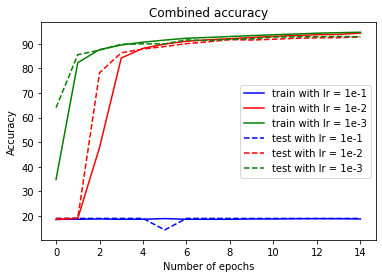

In [18]:
plt.plot(range(len(train_acc_list_01)), train_acc_list_01, 'b')
plt.plot(range(len(train_acc_list_001)), train_acc_list_001, 'r')
plt.plot(range(len(train_acc_list_0001)), train_acc_list_0001, 'g')

plt.plot(range(len(test_acc_list_01)), test_acc_list_01, color='b', linestyle='--')
plt.plot(range(len(test_acc_list_001)), test_acc_list_001,color='r', linestyle='--')
plt.plot(range(len(test_acc_list_0001)), test_acc_list_0001, color='g', linestyle='--')

plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Combined accuracy")
plt.legend(['train with lr = 1e-1', 'train with lr = 1e-2','train with lr = 1e-3',
            'test with lr = 1e-1','test with lr = 1e-2', 'test with lr = 1e-3'])
plt.show()

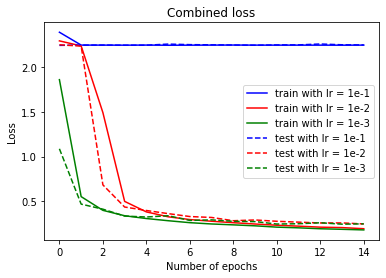

In [19]:
plt.plot(range(len(train_loss_list_01)), train_loss_list_01, 'b')
plt.plot(range(len(train_loss_list_001)), train_loss_list_001, 'r')
plt.plot(range(len(train_loss_list_0001)), train_loss_list_0001, 'g')

plt.plot(range(len(test_loss_list_01)), test_loss_list_01, color='b', linestyle='--')
plt.plot(range(len(test_loss_list_001)), test_loss_list_001,color='r', linestyle='--')
plt.plot(range(len(test_loss_list_0001)), test_loss_list_0001, color='g', linestyle='--')

plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Combined loss")
plt.legend(['train with lr = 1e-1', 'train with lr = 1e-2','train with lr = 1e-3',
            'test with lr = 1e-1','test with lr = 1e-2', 'test with lr = 1e-3'])
plt.show()